In [1]:
import matplotlib.pyplot as plt

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]


In [3]:
import numpy as np

In [4]:
import pathlib

In [5]:
import best

In [6]:
import sympy as sp

In [7]:
from scipy import optimize

In [8]:
class SemiAnalytical():
    def __init__(self, ells, MandelRep, Bvec):
                
        
        self.E = np.ones(6)
        self.P = self.getP()
        self.Q = self.getQ()
        
        self.M = MandelRep
        self.invM = np.linalg.inv(MandelRep)
        self.Bvec = Bvec
        
        self.K = self.P+np.sqrt(2)*self.Q
        
        self.ells = ells
        
        self.C = np.einsum('i, ij -> j', self.E.T, self.K)
        
        self._create_stuff()
        
            
    def getP(self):
        P = np.zeros((6, 6))
        P[0, 0] = 1
        P[1, 1] = 1
        P[2, 2] = 1
        return P
    
    def getQ(self):
        Q = np.zeros((6, 6))
        Q[3, 3] = 1
        Q[4, 4] = 1
        Q[5, 5] = 1
        return Q
    
    
    def integrate(self, y, ells):
        factor = 4*np.pi
        return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor
        
    def _create_stuff(self):
        P1 = np.zeros((6, 6))
        P1[0, 0] = 1

        P2 = np.zeros((6, 6))
        P2[0, 1] = 1

        P6 = np.zeros((6, 6))
        P6[0, 5] = 1

        Q = 2*P1.T@P2
        self.Z1 = Q-P6.T@P6
        self.Q1 = Q
        
        P1 = np.zeros((6, 6))
        P1[0, 0] = 1

        P3 = np.zeros((6, 6))
        P3[0, 2] = 1

        P5 = np.zeros((6, 6))
        P5[0, 4] = 1

        Q = 2*P1.T@P3
        self.Z2 = Q-P5.T@P5
        self.Q2 = Q
        
        P2 = np.zeros((6, 6))
        P2[0, 1] = 1

        P3 = np.zeros((6, 6))
        P3[0, 2] = 1

        P4 = np.zeros((6, 6))
        P4[0, 3] = 1

        Q = 2*P2.T@P3
        self.Z3 = Q-P4.T@P4
        self.Q3 = Q
        
    def _get_useful_matrices(self):
        Z1, Z2, Z3 = self.Z1, self.Z2, self.Z3
        
        invMandel = self.invM
        K = self.K
        C = self.C
        E = self.E
        
        Bvec = self.Bvec
        
        ells = self.ells
        
        return ells, Bvec, invMandel, Z1, Z2, Z3, K, C, E
    
    
    def getMVA():

        number = np.einsum('ij, ...jk, k, i', self.K, self.invM, self.C, self.E)
        Norm = self.integrate(number, self.ells)

        O = np.einsum('ij, ...jk, ...k, i', self.K, self.invM, self.Bvec, self.E)
        O = self.integrate(O, self.ells)

        A0 = MM@C/Norm
 
        return A0

    def gettotalfunctional(A0, FB):
        total = 0
        variance = np.einsum('...i, ...ik, ...k -> ...', A0, self.M, A0)
        variance = self.integrate(number, self.ells)
        bias = np.einsum('...i, ...i -> ...', A0, self.Bvec)
        bias = self.integrate(bias, self.ells)
        total = variance+FB*bias**2.
        return total
        
    def A0getter(self, FB):
        def getA0(x):
            
            newx = x.reshape((len(self.ells), 3))
            l1, l2, l3 = newx[:, 0], newx[:, 1], newx[:, 2]

            part = np.einsum('..., ...ij, jk -> ...ik', l1, self.invM, self.Z1)
            part += np.einsum('..., ...ij, jk -> ...ik', l2, self.invM, self.Z2)
            part += np.einsum('..., ...ij, jk -> ...ik', l3, self.invM, self.Z3)

            identity = np.diag(np.ones(6, dtype = float))
            R = identity+part

            invR = np.linalg.inv(R)

            MM = np.einsum('...ij, ...jk -> ...ik', invR, self.invM)

            number = np.einsum('ij, ...jk, k, i -> ...', self.K, MM, self.C, self.E)
            Norm = self.integrate(number, self.ells)

            O = np.einsum('ij, ...jk, ...k, i -> ...', self.K, MM, self.Bvec, self.E)
            O = self.integrate(O, self.ells)

            Ofactor = np.einsum('...ij, j, ...i -> ...', MM, self.C, self.Bvec)
            Ofactor = self.integrate(Ofactor, self.ells)

            Bfactor = np.einsum('...ij, ...j, ...i -> ...', MM, self.Bvec, self.Bvec)
            Bfactor = self.integrate(Bfactor, self.ells)

            den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor

            num = (Ofactor/Norm)*np.einsum('...ij, ...j -> ...i', MM, (O/Norm)*self.C-self.Bvec)

            A0 = MM@self.C/Norm+FB*num/den

            return A0
        return getA0
        
        
        

In [9]:
Tlabel = 'T'
Slabel = 'S'
Plabel = 'P'

In [10]:
cases = [Tlabel, Plabel, Slabel]

In [11]:
colors = {}
colors[Tlabel] = 'green'
colors[Plabel] = 'blue'
colors[Slabel] = 'orange'

In [12]:
p = pathlib.Path('../qelensingcomb/output/')
def getdir(l1, l2 = None, l3 = None):
    if (l2 is not None) and (l3 is not None):
        return f'h{l1}s{l2}b{l3}/tsz/'
    else:
        l = l1
        return f'h{l}s{l}b{l}/tsz/'

getT = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'T_tsz_148.npy')#[index, index]
getP = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'P_tsz_148.npy')#[index, index]
getS = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'S_tsz_148.npy')#[index, index]
getPC = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'PC_tsz_148.npy')
getells = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'ells_tsz_148.npy')
getkk = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'kk_tsz_148.npy')
getkg = lambda l1, l2, l3: np.load(p/getdir(l1, l2, l3)/'kg_tsz_148.npy')

In [13]:
l1, l2, l3 = 2500, 4000, 4000

In [14]:
ells = getells(l1, l2, l3)

In [15]:
sel = (ells>30) & (ells<1200)

In [16]:
ells = ells[sel]

In [17]:
clkk = getkk(l1, l2, l3)[sel]

In [18]:
clkg = getkg(l1, l2, l3)[sel]

In [19]:
theta = np.load(p/getdir(l1, l2, l3)/'theta_tsz_148.npy')[..., sel]

In [20]:
theta = theta/clkk**2.
theta = np.nan_to_num(theta)

In [21]:
thetacross = np.load(p/getdir(l1, l2, l3)/'thetacross_tsz_148.npy')[..., sel]

In [22]:
thetacross = thetacross/clkg**2.
thetacross = np.nan_to_num(thetacross)

In [23]:
N = np.load(p/getdir(l1, l2, l3)/'N_tsz_148.npy')[..., sel]

In [24]:
indices_pairs = [(0, 0), (1, 1), (2, 2), (1, 2), (2, 0), (0, 1)]

In [25]:
MandelMatrix = np.ones((len(ells), 6, 6))

In [26]:
theta.shape

(3, 3, 3, 3, 8)

In [27]:
for A, pairA in enumerate(indices_pairs):
    for B, pairB in enumerate(indices_pairs):
        i, j = pairA
        m, n = pairB
        factorA = 1. if i == j else np.sqrt(2)
        factorB = 1. if m == n else np.sqrt(2)
        
        MandelMatrix[:, A, B] = factorA*factorB*theta[i, j, m, n]

In [28]:
B = getT(l1, l2, l3)+getP(l1, l2, l3)+getS(l1, l2, l3)
B = B[..., sel]/clkk

In [29]:
BC = getPC(l1, l2, l3)[..., sel]/clkg

## Differential evolution solution

In [115]:
FB = 0.

In [116]:
Optimizerkk = best.Opt(['hu_ok', 'shear', 'bh'], 30, 1200, ells, ells*0.+1., 
                       np.nan_to_num(theta), np.nan_to_num(B), np.nan_to_num(N))

In [117]:
optversion = {'weights_name': 'absbias', 'sum_biases_squared': False, 'abs_biases': True, 'bias_squared': False,
                      'color': 'purple', 'latexformula': '\sigma^2(\hat{A}_{\rm{comb}})+\left(\int_{\vec{L}}\vec{a}^TB\vec{a}\right)^2'}

In [118]:
result_0 = Optimizerkk.optimize(optversion, method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000168
Generation 100 has ChiSquare: 0.000081
Generation 200 has ChiSquare: 0.000061
Generation 300 has ChiSquare: 0.000052
Generation 400 has ChiSquare: 0.000052
Generation 500 has ChiSquare: 0.000050
Generation 600 has ChiSquare: 0.000047
Generation 700 has ChiSquare: 0.000044
Generation 800 has ChiSquare: 0.000044
Generation 900 has ChiSquare: 0.000044
Generation 1000 has ChiSquare: 0.000044
Generation 1100 has ChiSquare: 0.000043
Generation 1200 has ChiSquare: 0.000043
Generation 1300 has ChiSquare: 0.000043
Generation 1400 has ChiSquare: 0.000043
Generation 1500 has ChiSquare: 0.000043
Generation 1600 has ChiSquare: 0.000043
Generation 1700 has ChiSquare: 0.000043
Generation 1800 has ChiSquare: 0.000043
Generation 1900 has ChiSquare: 0.000043
Generation 2000 has ChiSquare: 0.000043
Generation 2100 has ChiSquare: 0.000043
Generation 2200 has ChiSquare: 0.000043
Generation 2300 has ChiSquare: 0.000043
Ge

In [35]:
FB = 1.

In [36]:
result_1 = Optimizerkk.optimize(optversion, method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000750
Generation 100 has ChiSquare: 0.000454
Generation 200 has ChiSquare: 0.000400
Generation 300 has ChiSquare: 0.000314
Generation 400 has ChiSquare: 0.000255
Generation 500 has ChiSquare: 0.000255
Generation 600 has ChiSquare: 0.000255
Generation 700 has ChiSquare: 0.000255
Generation 800 has ChiSquare: 0.000255
STOP("ChangeOverGeneration with {'tolerance': 1e-11, 'generations': 500}")
Optimization terminated successfully.
         Current function value: 0.000255
         Iterations: 896
         Function evaluations: 48549
Weights in columns [[0.25924512 0.47611716 0.26463772]
 [0.22449134 0.31395842 0.46155025]
 [0.11941364 0.50700773 0.37357863]
 [0.80062271 0.13192881 0.06744848]
 [0.55532525 0.09843864 0.3462361 ]
 [0.54202976 0.03720514 0.4207651 ]
 [0.81036677 0.16772653 0.02190671]
 [0.58655959 0.06656937 0.34687104]]
Sum [1. 1. 1. 1. 1. 1. 1. 1.]


### Solving for f_b*b^2 only 


In [167]:
from mystic.penalty import linear_equality, quadratic_equality

import mystic.solvers as my

from mystic.monitors import VerboseMonitor

def constraint_eq(x):
    x = np.array(x)
    a = Optimizerkk.get_a(x, inv_variance = False)
    a[:, 2] = 1-a[:, 0]-a[:, 1]
    x[:-Optimizerkk.nbins] = a.flatten()
    return x


def penalty1(x):
    x = np.array(x)
    b = x[-Optimizerkk.nbins:]
    res = Optimizerkk.integerate_discrete(b, Optimizerkk.ells_selected)
    return 1-res

k = 1e20

@quadratic_equality(condition=penalty1, k = k)
def penalty(x):
    return 0.0 

bounds = [0., 1.]

Ne = len(Optimizerkk.estimators)

dims = Ne+1

bnds = [(bounds[0], bounds[1]) for i in range(dims*Optimizerkk.nbins)]
bnds = tuple(bnds)

In [168]:
def Tfunction(x):
    x = np.array(x)
    a = Optimizerkk.get_a(x, False).T
    w_ = x[-Optimizerkk.nbins:]
    Bintegrated = np.einsum('ij..., i..., j... -> ...', Optimizerkk.biases_selected, a, a)*w_
    Bintegrated = Optimizerkk.integerate_discrete(Bintegrated, Optimizerkk.ells_selected)
    Tij = Optimizerkk.biases_selected*Bintegrated*w_
    e = np.ones(Ne)
    Tij = np.einsum('ij..., i..., j... -> ...', Tij, a, a)
    result = Optimizerkk.integerate_discrete(Tij, Optimizerkk.ells_selected)
    return result

In [169]:
x0 = result_0.x

In [170]:
mon = VerboseMonitor(100)

resultfromT = my.diffev(Tfunction, x0, npop = 10*len(list(bnds)), bounds = bnds, ftol = 1e-6, gtol = 1000, maxiter = 1024**3, 
                      maxfun = 1024**3, constraints = constraint_eq, penalty = penalty, full_output = True, itermon = mon)

Generation 0 has ChiSquare: 0.000379
Generation 100 has ChiSquare: 0.000349
Generation 200 has ChiSquare: 0.000280
Generation 300 has ChiSquare: 0.000170
Generation 400 has ChiSquare: 0.000170
Generation 500 has ChiSquare: 0.000170
Generation 600 has ChiSquare: 0.000170
Generation 700 has ChiSquare: 0.000123
Generation 800 has ChiSquare: 0.000110
Generation 900 has ChiSquare: 0.000102
Generation 1000 has ChiSquare: 0.000100
Generation 1100 has ChiSquare: 0.000100
Generation 1200 has ChiSquare: 0.000092
Generation 1300 has ChiSquare: 0.000075
Generation 1400 has ChiSquare: 0.000068
Generation 1500 has ChiSquare: 0.000067
Generation 1600 has ChiSquare: 0.000067
Generation 1700 has ChiSquare: 0.000067
Generation 1800 has ChiSquare: 0.000066
Generation 1900 has ChiSquare: 0.000066
Generation 2000 has ChiSquare: 0.000064
Generation 2100 has ChiSquare: 0.000064
Generation 2200 has ChiSquare: 0.000064
Generation 2300 has ChiSquare: 0.000064
Generation 2400 has ChiSquare: 0.000064
Generation 2

In [213]:
a_from_T = Optimizerkk.get_a(resultfromT[0], False)
a_from_T.sum(axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [214]:
a_1 = Optimizerkk.get_a(result_1.x, False)

In [215]:
a_0 = Optimizerkk.get_a(result_0.x, False)

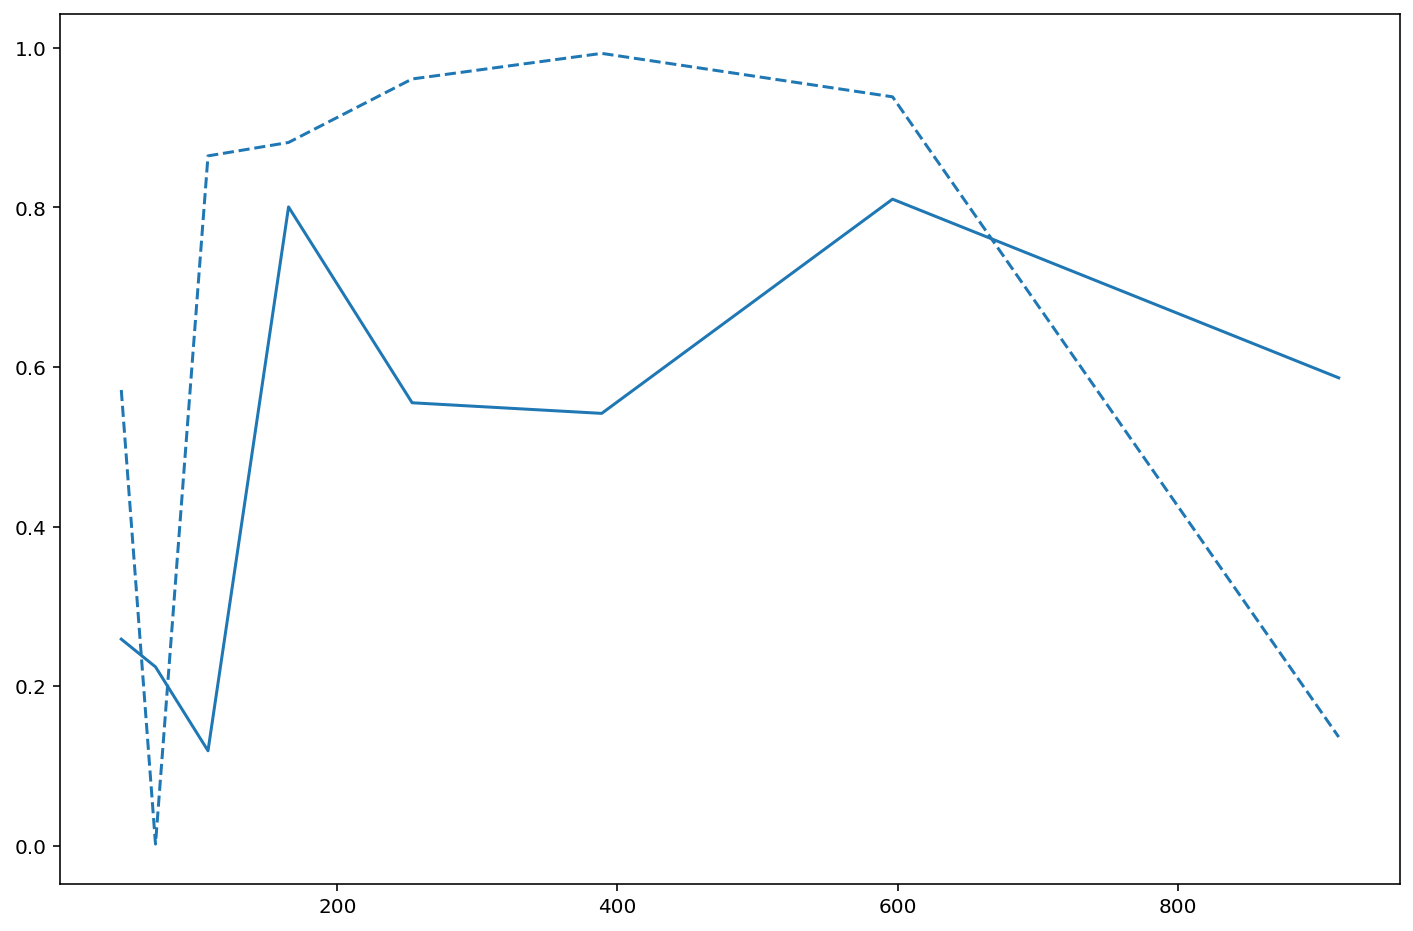

In [216]:
for i in range(1):
    p = plt.plot(ells, a_1[:, i])
    plt.plot(ells, a_from_T[:, i], ls = '--', color = p[0].get_color())

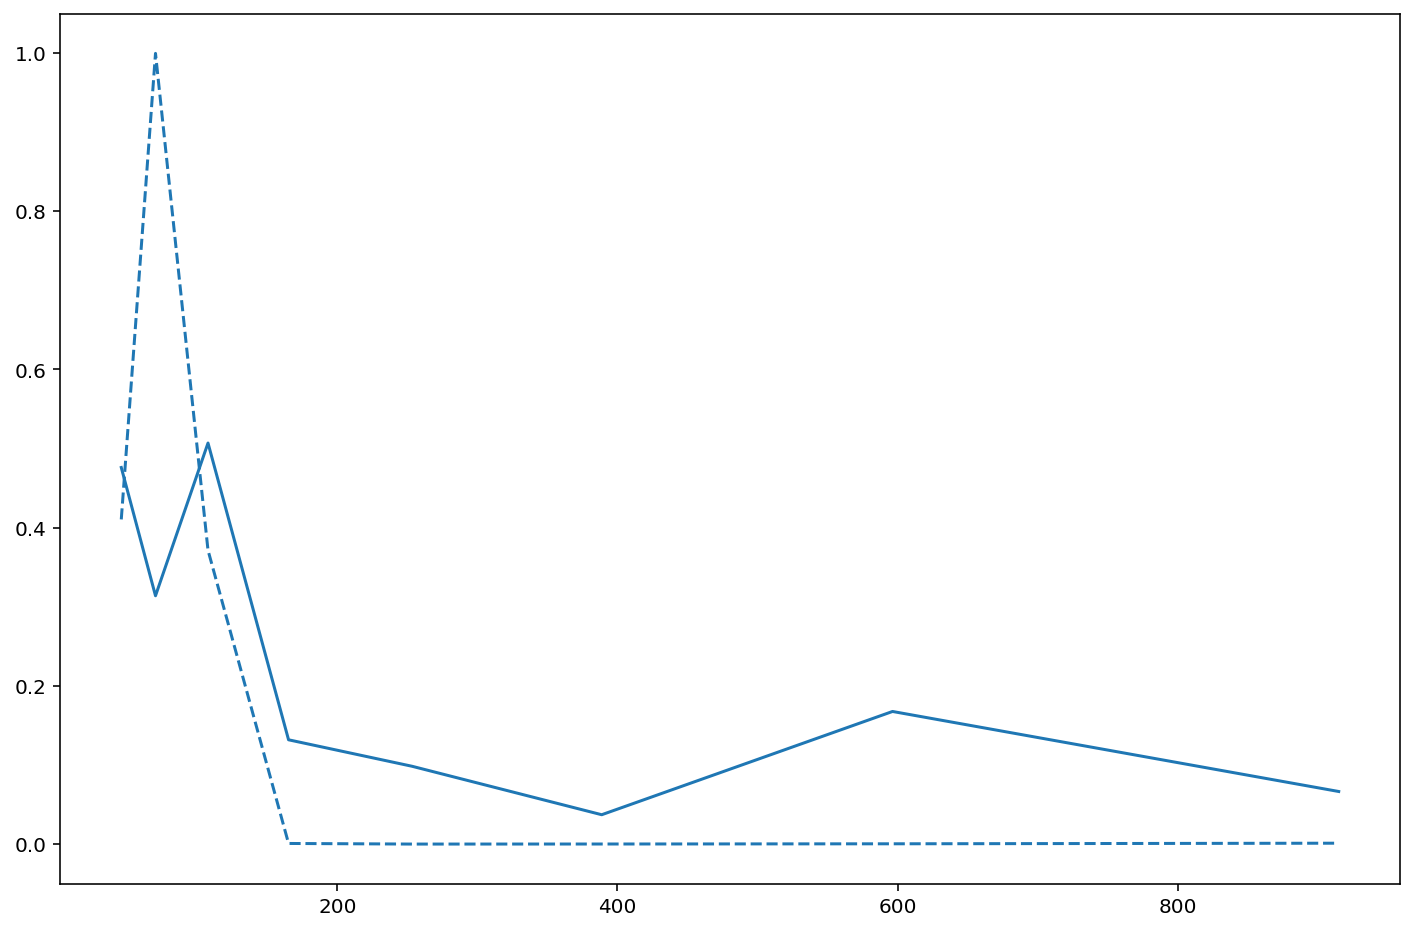

In [126]:
for i in range(1, 2):
    p = plt.plot(ells, a_1[:, i])
    plt.plot(ells, a_from_T[:, i], ls = '--', color = p[0].get_color())

In [96]:
e = np.ones(3)

In [99]:
Optimizerkk.integerate_discrete(np.einsum('ij..., i, j -> ...', T_0, e, e), Optimizerkk.ells_selected)

3400.937109675292

In [100]:
Optimizerkk.integerate_discrete(np.einsum('ij..., i, j -> ...', T_1, e, e), Optimizerkk.ells_selected)

2336.3950993093968

In [92]:
def getTbase(w_0, a_0):
    integral = Optimizerkk.integerate_discrete(w_0*np.einsum('...i, ...j, ij... -> ...', a_0, a_0, Optimizerkk.biases_selected), Optimizerkk.ells_selected)
    bias_part = Optimizerkk.biases_selected*integral
    variance_part = np.einsum('...m, ...n, ijmn..., ... -> ij...', a_0, a_0, Optimizerkk.theta_selected, w_0)
    T_0 = variance_part+bias_part
    return T_0

def getT(result):
    w_0 = result.x[-Optimizerkk.nbins:]
    a_0 = Optimizerkk.get_a(result.x, inv_variance = False)
    T_0 = getTbase(w_0, a_0)
    return T_0

In [93]:
T_0 = getT(result_0)
T_1 = getT(result_1)

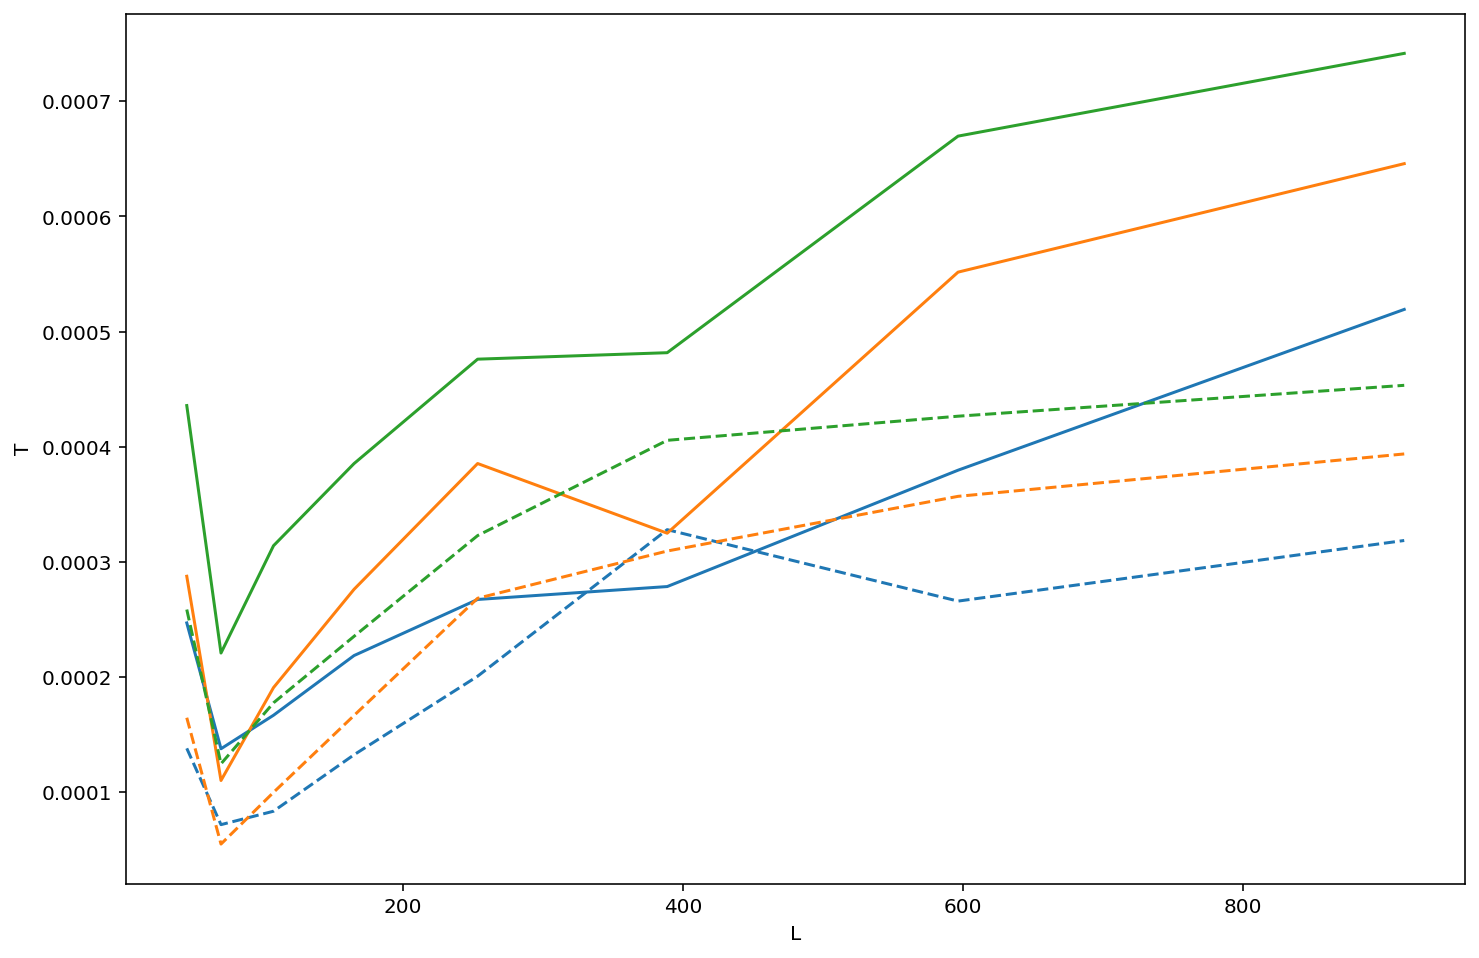

In [94]:
Ne = len(Optimizerkk.estimators)
for i in range(3):
    p = plt.plot(Optimizerkk.ells_selected, T_0[i, j])
    plt.plot(Optimizerkk.ells_selected, T_1[i, j], color = p[0].get_color(), ls = '--')
plt.ylabel('T')
plt.xlabel('L')
plt.show()

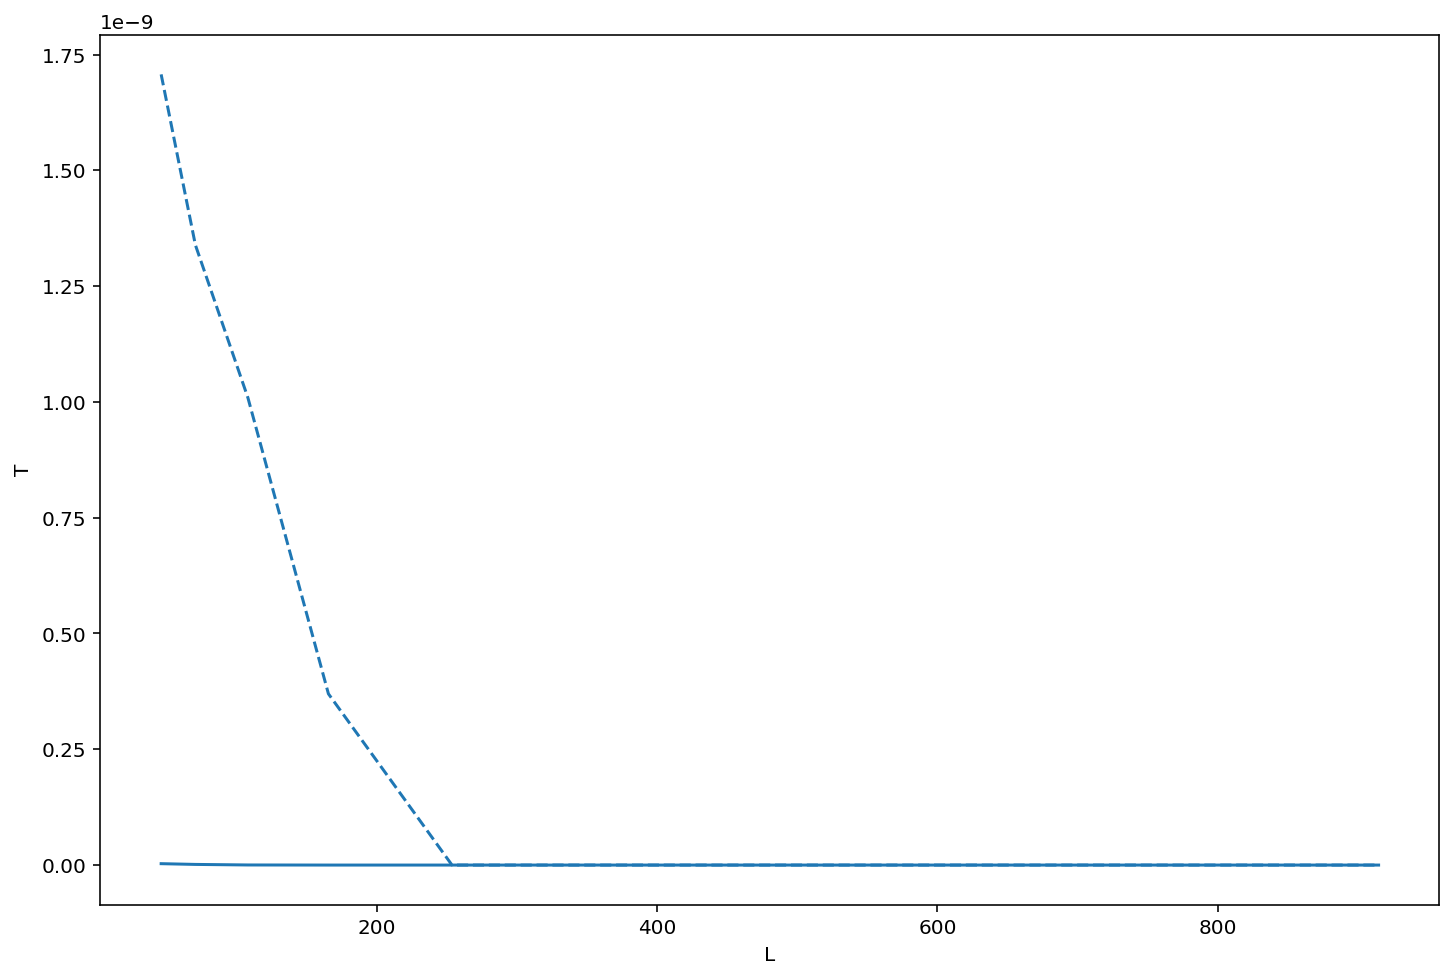

In [710]:
Ne = len(Optimizerkk.estimators)
for i in range(1, 2):
    p = plt.plot(Optimizerkk.ells_selected, T_0[i, j]*w_0*a_0[..., i])
    plt.plot(Optimizerkk.ells_selected, T_1[i, j]*w_1*a_1[..., i], color = p[0].get_color(), ls = '--')
plt.ylabel('T')
plt.xlabel('L')
plt.show()

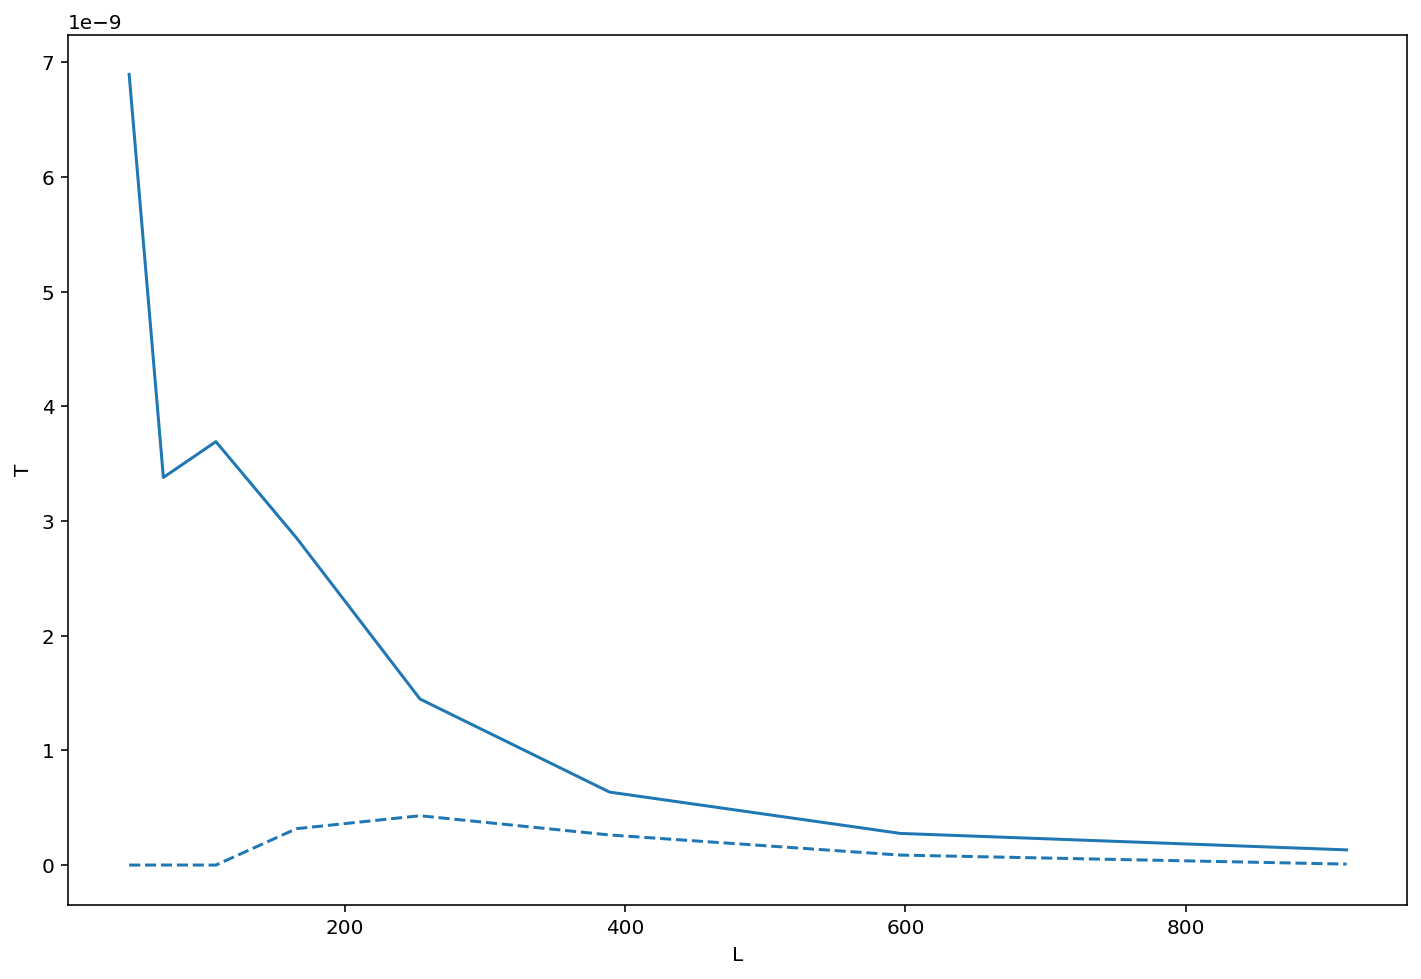

In [711]:
Ne = len(Optimizerkk.estimators)
for i in range(2, 3):
    p = plt.plot(Optimizerkk.ells_selected, T_0[i, j]*w_0*a_0[..., i])
    plt.plot(Optimizerkk.ells_selected, T_1[i, j]*w_1*a_1[..., i], color = p[0].get_color(), ls = '--')
plt.ylabel('T')
plt.xlabel('L')
plt.show()

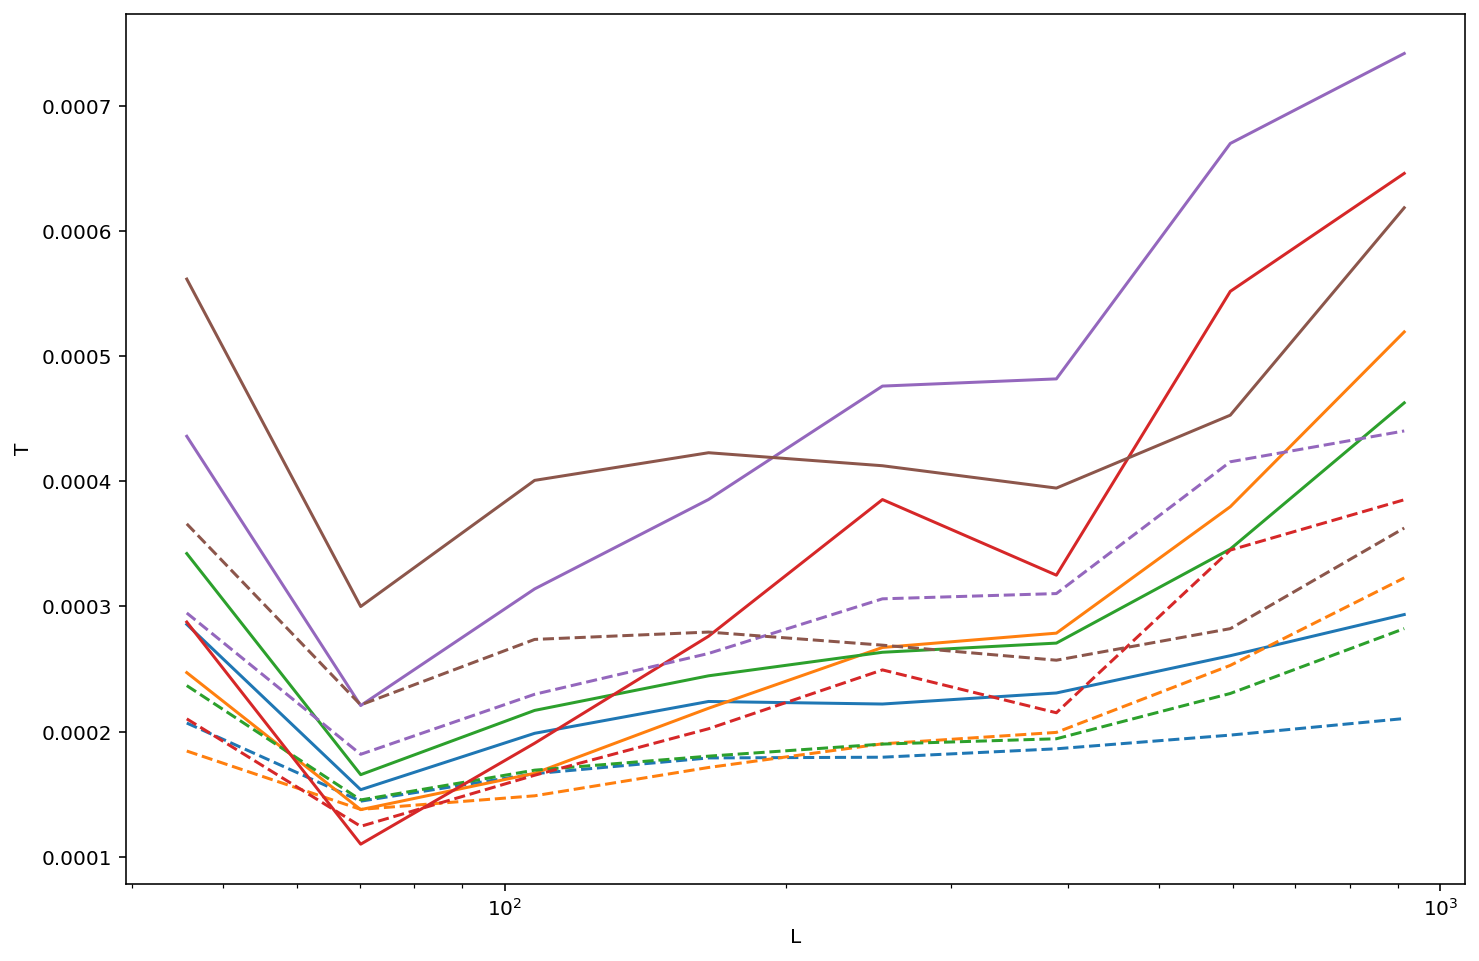

In [717]:
Ne = len(Optimizerkk.estimators)
for i in range(Ne):
    for j in range(i, Ne):
        p = plt.plot(Optimizerkk.ells_selected, T_0[i, j])
        plt.plot(Optimizerkk.ells_selected, T_1[i, j], color = p[0].get_color(), ls = '--')
plt.ylabel('T')
plt.xlabel('L')
plt.xscale('log')
plt.show()

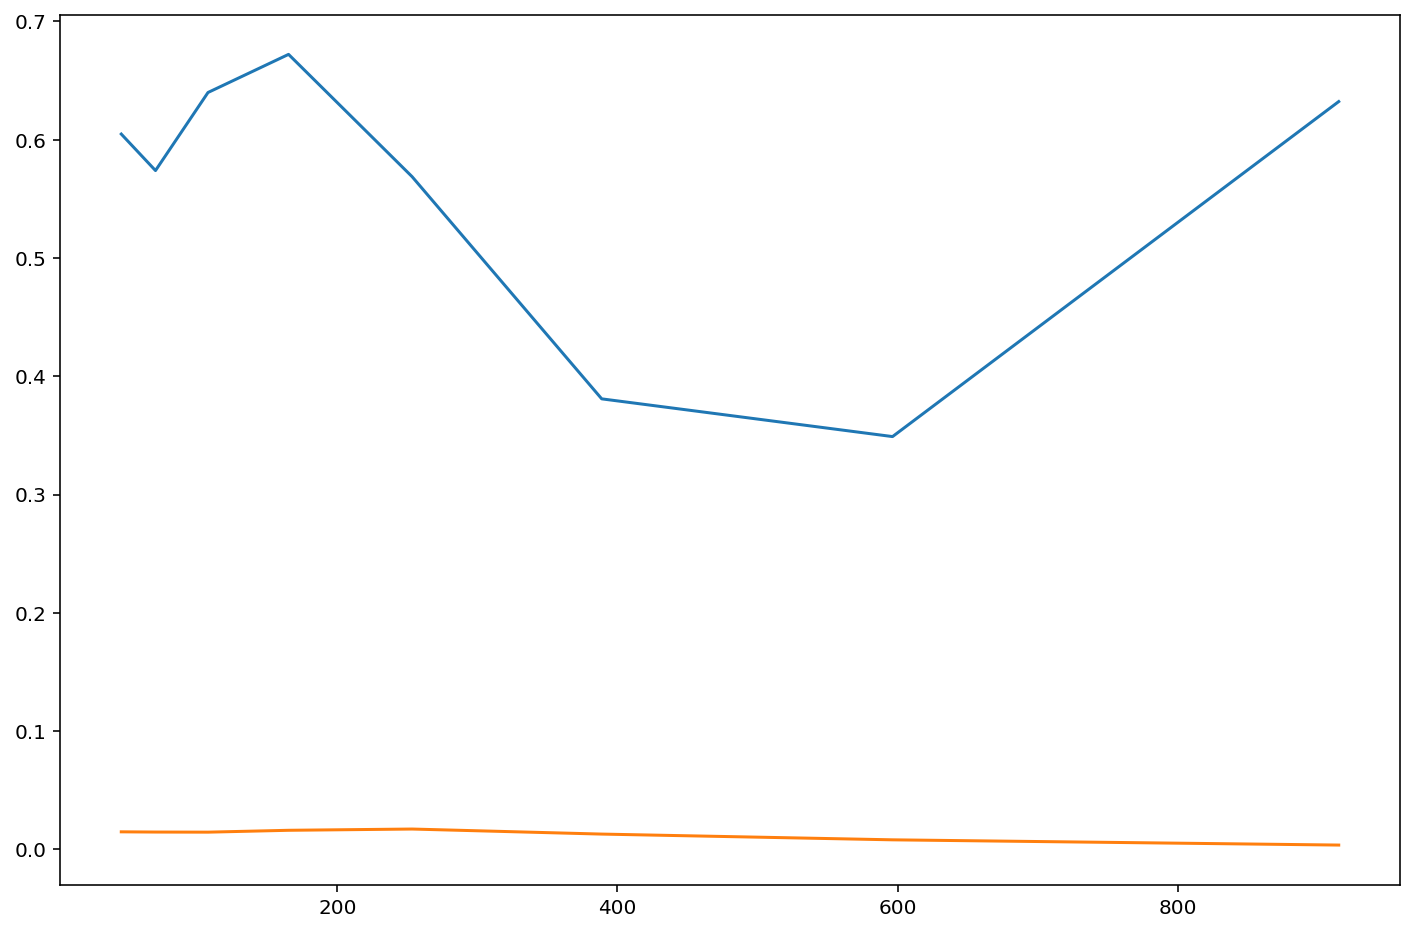

In [664]:
plt.plot(Optimizerkk.ells_selected, result_1.ws[0])
plt.plot(Optimizerkk.ells_selected, result_0.ws[0])

In [665]:
w_1 = result_1.x[-Optimizerkk.nbins:]
a_1 = Optimizerkk.get_a(result_1.x, inv_variance = False)

In [666]:
w_0 = result_0.x[-Optimizerkk.nbins:]
a_0 = Optimizerkk.get_a(result_0.x, inv_variance = False)

In [667]:
TT = np.rollaxis(T_0, -1, 0)
TT.shape

(8, 3, 3)

In [668]:
a_prime_next.sum(axis = 1)

array([ 6.93472526e-07,  2.20714830e-06,  1.46522020e-06,  1.56002700e-06,
        1.72128246e-06,  1.66831096e-06,  2.03727607e-06, -7.64838277e-08])

In [669]:
def constraint_eq(x):
    x = np.array(x)
    a = Optimizerkk.get_a(x, inv_variance = False)
    a[:, 2] = 1-a[:, 0]-a[:, 1]
    x[:-Optimizerkk.nbins] = a.flatten()
    return x


def penalty1(x):
    x = np.array(x)
    b = x[-Optimizerkk.nbins:]
    res = Optimizerkk.integerate_discrete(b, Optimizerkk.ells_selected)
    return 1-res

In [670]:
from mystic.penalty import linear_equality, quadratic_equality

import mystic.solvers as my

In [671]:
k = 1e20

@quadratic_equality(condition=penalty1, k = k)
def penalty(x):
    return 0.0 

In [672]:

bounds = [0., 1.]

dims = Ne+1

bnds = [(bounds[0], bounds[1]) for i in range(dims*Optimizerkk.nbins)]
bnds = tuple(bnds)

In [673]:
T_0.shape

(3, 3, 8)

In [674]:
def function(x):
        x = np.array(x)
        a = Optimizerkk.get_a(x, inv_variance = False)
        weight_per_l = w_0
        somma = np.einsum('...i, ...j, ij...->...', a_0, a_0, T_0)
        somma_integrata = Optimizerkk.integerate_discrete(somma*weight_per_l, Optimizerkk.ells_selected)
        return somma_integrata
    
function(x0)

0.00042249837245903745

In [718]:
def function(x):
        x = np.array(x)
        a = Optimizerkk.get_a(x, inv_variance = False)
        weight_per_l = w_1
        somma = np.einsum('...i, ...j, ij...->...', a_1, a_1, T_1)
        somma_integrata = Optimizerkk.integerate_discrete(somma*weight_per_l, Optimizerkk.ells_selected)
        return somma_integrata
    
function(x0)

0.00019962433776720936

In [726]:
e = np.ones(Ne)
TT = np.rollaxis(T_0, -1, 0)
#TT = T_0
T_s = TT

x0 = a_0.flatten()
x0 = np.append(x0, w_0)

for s in range(2):
    
    def function(x):
        x = np.array(x)
        a = Optimizerkk.get_a(x, inv_variance = False)
        weight_per_l = x[-Optimizerkk.nbins:]
        somma = np.einsum('...i, ...j, ij...->...', a, a, T_s)
        somma_integrata = Optimizerkk.integerate_discrete(somma*weight_per_l, Optimizerkk.ells_selected)
        return somma_integrata
    
    
    #result = my.diffev(function, x0, npop = 10*len(list(bnds)), bounds = bnds, ftol = 1e-6, gtol = 300, maxiter = 1024**3, 
    #                   maxfun = 1024**3, constraints = constraint_eq, penalty = penalty, full_output = True)
    
    #ris = result[0]
    
    #a_next = Optimizerkk.get_a(ris, inv_variance = False)
    #w_next = ris[-Optimizerkk.nbins:]

    invT_s = np.linalg.inv(T_s)
    norma = Optimizerkk.integerate_discrete(np.einsum('i, j, ...ij -> ...', e, e, invT_s), Optimizerkk.ells_selected)
    a_prime_next = np.einsum('...ij, j -> ...i', invT_s, e)/norma
    w_next = np.einsum('...i, i', a_prime_next, e)**2
    a_next = (a_prime_next.T/np.sqrt(w_next)).T
    #print(norma)
        
    TT = getTbase(w_next, a_next)
    TT = np.rollaxis(TT, -1, 0)
    T_s = TT
    w_s = w_next
    
    

In [727]:
w_next

array([1.61197700e-12, 1.53799083e-11, 6.26150911e-12, 7.68980735e-12,
       4.52106052e-12, 1.94401463e-12, 8.22627454e-13, 1.04615200e-12])

In [721]:
T_next = getTbase(w_next, a_next)

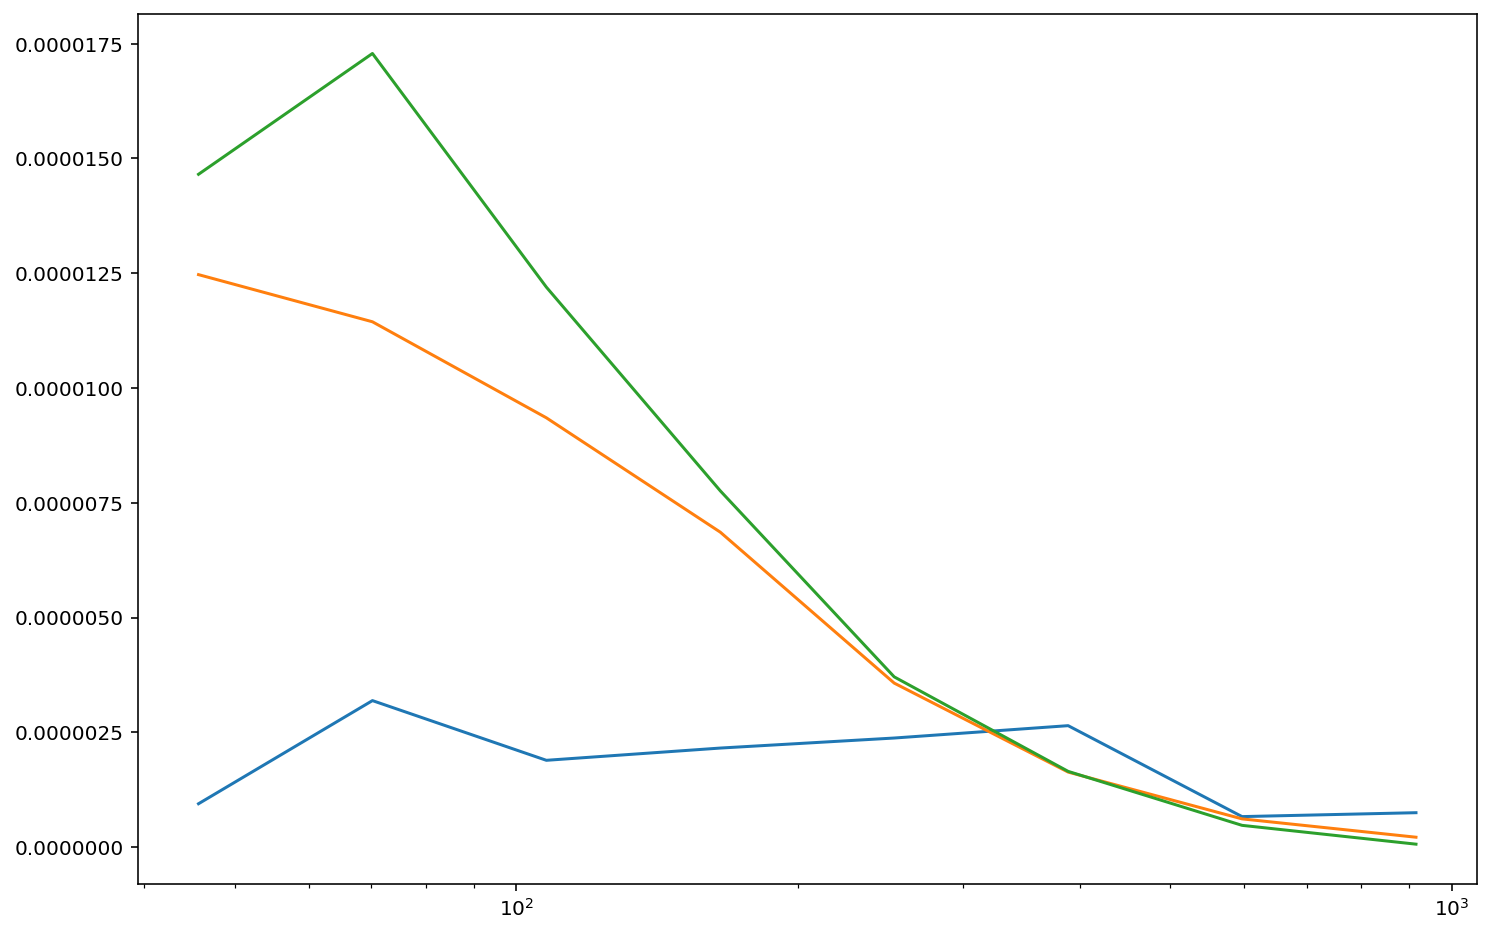

In [724]:
plt.plot(ells, w_next)
plt.plot(ells, w_0)
plt.plot(ells, w_1)
plt.xscale('log')

In [702]:
a_0

array([[1.47977501e-02, 5.53115841e-04, 9.84649134e-01],
       [1.46117205e-02, 5.52169934e-04, 9.84836110e-01],
       [1.45202618e-02, 7.24408921e-05, 9.85407297e-01],
       [1.60968353e-02, 3.50221484e-06, 9.83899663e-01],
       [1.71576021e-02, 2.04500829e-06, 9.82840353e-01],
       [1.28912137e-02, 3.45472209e-07, 9.87108441e-01],
       [8.03873762e-03, 8.84973657e-07, 9.91960377e-01],
       [3.60615322e-03, 1.91015214e-06, 9.96391937e-01]])

In [703]:
a_next

array([[2.62951783e-02, 4.87684810e-03, 9.68827974e-01],
       [6.40152234e-02, 2.69774056e-04, 9.35715003e-01],
       [9.71435930e-01, 8.14840764e-04, 2.77492289e-02],
       [1.38419185e-01, 5.18273630e-06, 8.61575632e-01],
       [7.00094280e-02, 2.04160627e-05, 9.29970156e-01],
       [2.49524425e-01, 1.72771646e-06, 7.50473847e-01],
       [4.49635232e-02, 1.12496348e-05, 9.55025227e-01],
       [4.17334298e-03, 7.74262454e-05, 9.95749231e-01]])

In [704]:
a_1

array([[6.04809033e-01, 3.95188735e-01, 2.23196864e-06],
       [5.73941965e-01, 4.25948612e-01, 1.09422851e-04],
       [6.39955639e-01, 3.60043067e-01, 1.29451376e-06],
       [6.72186655e-01, 1.81551740e-01, 1.46261605e-01],
       [5.68745547e-01, 1.08617863e-07, 4.31254345e-01],
       [3.80907373e-01, 1.99913943e-08, 6.19092607e-01],
       [3.49003901e-01, 2.78381705e-08, 6.50996072e-01],
       [6.32289060e-01, 2.07146351e-07, 3.67710733e-01]])

In [725]:
Optimizerkk.integerate_discrete(w_next, Optimizerkk.ells_selected)

1.7476346453896646e-06

In [683]:
Optimizerkk.integerate_discrete(w_next*np.einsum('...i, ...j, ij... -> ...', a_next, a_next, T_next), Optimizerkk.ells_selected)

0.0003877736220320884

In [690]:
Optimizerkk.integerate_discrete(w_1*np.einsum('...i, ...j, ij... -> ...', a_1, a_1, T_1), Optimizerkk.ells_selected)

0.00019962433776720936

In [687]:
Optimizerkk.integerate_discrete(w_0*np.einsum('...i, ...j, ij... -> ...', a_0, a_0, T_0), Optimizerkk.ells_selected)

0.00042249837245903745

In [688]:
Optimizerkk.integerate_discrete(w_1*np.einsum('...i, ...j, ij... -> ...', a_1, a_1, T_0), Optimizerkk.ells_selected)

0.00027395149069834825

### Small check to understand minimization

In [328]:
import mystic.solvers as my

In [329]:
theta0 = theta*0.+1.
theta0.shape

(3, 3, 3, 3, 8)

In [330]:
B0 = B*0.+1.
B0.shape

(3, 3, 8)

In [331]:
FB0 = 1.

In [332]:
np.zeros(24).reshape((3, -1)).shape

(3, 8)

In [333]:
Optimizerkk.nbins

8

In [358]:
resh = lambda x: np.array(x).reshape((3, -1))

funcN_ = lambda x: np.einsum('i..., j..., m..., n..., ijmn... -> ...', x, x, x, x, theta0)
funcN = lambda x: funcN_(resh(x))

funcB_ = lambda x: np.einsum('i..., j..., ij... -> ...', x, x, B0)*FB0
funcB = lambda x: funcB_(resh(x))

func = lambda x: np.trapz(Optimizerkk.ells*(funcN(x)), Optimizerkk.ells)+np.trapz(Optimizerkk.ells*(funcB(x)), Optimizerkk.ells)**2.

func = lambda x: np.sum(Optimizerkk.ells*(funcN(x)))+np.sum(Optimizerkk.ells*(funcB(x)))**2.


x0 = np.zeros(3*8)
x0[0] = 1

def constraint_eq(x):
    x = np.array(x)
    x = x.reshape((3, -1))
    x[:, 2] = 1-x[:, 0]-x[:, 1]
    return x.flatten()

result = my.diffev(func, x0, npop = 10*len(list(x0)), bounds = [(0, 1)]*3*8, ftol = 1e-7, gtol = 2000, maxiter = 1024**3, maxfun = 1024**3, constraints = constraint_eq, full_output = True)

Optimization terminated successfully.
         Current function value: 39577.634316
         Iterations: 5620
         Function evaluations: 135562


In [359]:
funcN(result[0])

array([4.29258405e+00, 7.93495904e-01, 1.44729241e-01, 8.74279335e-33,
       1.25682667e-33, 4.65568561e-34, 1.87929037e-34, 1.78631573e-34])

In [367]:
funcB(result[0])

array([2.07185522e+00, 8.90783870e-01, 3.80432966e-01, 9.35029056e-17,
       3.54517514e-17, 2.15770378e-17, 1.37087212e-17, 1.33653123e-17])

In [361]:
np.sum((funcN(result[0]))*Optimizerkk.ells)

267.6568172886868

In [368]:
np.sum((funcB(result[0]))*Optimizerkk.ells)**2

39309.977498828026

In [355]:
np.trapz(Optimizerkk.ells*(funcB(result[0])), Optimizerkk.ells)**2

61565873.18429531

In [349]:
result[0]

array([9.50392000e-01, 5.05555777e-03, 4.45524425e-02, 8.29884677e-10,
       1.01674111e-09, 4.33065505e-10, 1.19673563e-10, 8.07339373e-11,
       3.95133140e-01, 5.35415393e-01, 6.94514666e-02, 1.82077144e-10,
       1.28398980e-09, 4.52532612e-10, 2.72252538e-10, 3.21332186e-10,
       8.49109116e-01, 2.47293956e-02, 1.26161488e-01, 4.83970316e-12,
       8.22212785e-10, 4.84875546e-11, 7.04149797e-10, 1.84788545e-10])

In [350]:
result[0].sum()

3.000000006756762

## Go back to original problem

In [180]:
Optimizerkk.biasf(result.x)

0.001680406752694081

In [181]:
Optimizerkk.noisef(result.x)

0.00877065654364353

In [182]:
Optimizerkk.noisef(result.x)/Optimizerkk.biasf(result.x) 

5.219365209989865

In [158]:
Optimizerkk.noisef(result.x)/Optimizerkk.biasf(result.x) #old

1.9209635538884131

In [137]:
Optimizerkk.f(result.x)

0.0001324488748684323

In [147]:
Nits = len(Optimizerkk.monitor.x)

In [148]:
fits = np.array(Optimizerkk.monitor.y)

In [149]:
xits = np.arange(1, Nits+1)

In [150]:
bits = []
nits = []

for i in range(Nits):
    xx = np.array(Optimizerkk.monitor.x[i])
    bits += [Optimizerkk.biasf(xx)]
    nits += [Optimizerkk.noisef(xx)]
    
bits = np.array(bits)
nits = np.array(nits)

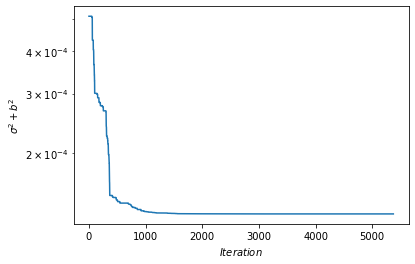

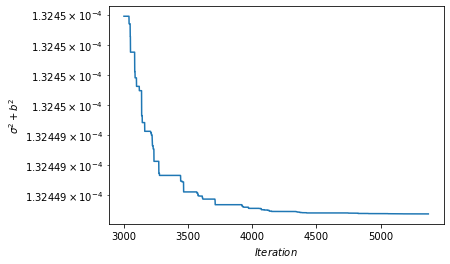

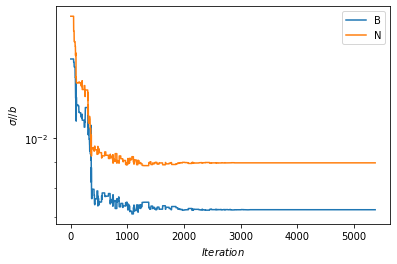

In [151]:
plt.plot(xits, fits)
plt.yscale('log')
plt.ylabel('$\sigma^2+b^2$')
plt.xlabel('$Iteration$')
plt.show()

sel = xits>3000
plt.plot(xits[sel], fits[sel])
plt.yscale('log')
plt.ylabel('$\sigma^2+b^2$')
plt.xlabel('$Iteration$')
plt.show()


plt.plot(xits, bits, label = 'B')
plt.plot(xits, nits, label = 'N')
plt.yscale('log')
plt.ylabel('$\sigma // b$')
plt.xlabel('$Iteration$')
plt.legend()
plt.show()

In [152]:
nits[sel]/bits[sel]

array([1.23707522, 1.23707522, 1.23707522, ..., 1.2367945 , 1.2367945 ,
       1.2367945 ])

In [96]:
nits[sel]/bits[sel]

array([1.03650757, 1.03650757, 1.03650757, ..., 1.04896554, 1.04896554,
       1.04896554])

In [65]:
nits[sel]/bits[sel] #oldcase

array([1.23516628, 1.23516628, 1.23516628, ..., 1.23679672, 1.23679672,
       1.23679672])

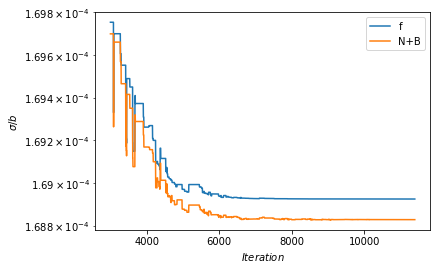

In [97]:
plt.plot(xits[sel], nits[sel]**2+bits[sel]**2, label = 'f')
plt.plot(xits[sel], (nits+bits)[sel]**2/2, label = 'N+B')
plt.yscale('log')
plt.ylabel('$\sigma / b$')
plt.xlabel('$Iteration$')
plt.legend()
plt.show()

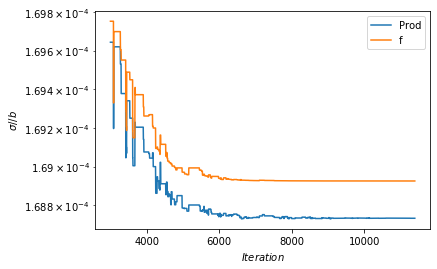

In [98]:
plt.plot(xits[sel], 2*np.sqrt(nits**2*bits**2)[sel], label = 'Prod')
plt.plot(xits[sel], nits[sel]**2+bits[sel]**2, label = 'f')
plt.yscale('log')
plt.ylabel('$\sigma // b$')
plt.xlabel('$Iteration$')
plt.legend()
plt.show()

In [157]:
a1, a2, a3, w = result.ws

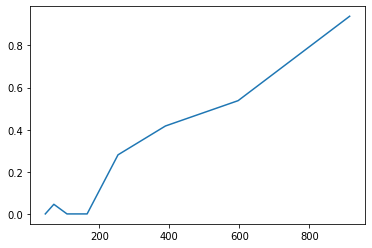

In [158]:
plt.plot(ells, a1)

In [159]:
Asol = np.zeros((len(a1), 6))
Asol[:, 0] = a1**2*w
Asol[:, 1] = a2**2*w
Asol[:, 2] = a3**2*w
Asol[:, 3] = a2*a3*np.sqrt(2)*w
Asol[:, 4] = a1*a3*np.sqrt(2)*w
Asol[:, 5] = a1*a2*np.sqrt(2)*w

## Cross Optimization

In [176]:
ells.shape

(14,)

In [181]:
Optimizerkg = best.Opt(['hu_ok', 'shear', 'bh'], 30, 1200, ells, ells*0.+1., 
                       np.nan_to_num(thetacross), np.nan_to_num(BC), np.nan_to_num(N))

In [182]:
resultkg = Optimizerkg.optimize(optversion, method = 'diff-ev', gtol = 1000 ,bounds = [0, 1]
                              , noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000160
Generation 100 has ChiSquare: 0.000097
Generation 200 has ChiSquare: 0.000077
Generation 300 has ChiSquare: 0.000067
Generation 400 has ChiSquare: 0.000066
Generation 500 has ChiSquare: 0.000064
Generation 600 has ChiSquare: 0.000064
Generation 700 has ChiSquare: 0.000063
Generation 800 has ChiSquare: 0.000063
Generation 900 has ChiSquare: 0.000063
Generation 1000 has ChiSquare: 0.000063
Generation 1100 has ChiSquare: 0.000061
Generation 1200 has ChiSquare: 0.000061
Generation 1300 has ChiSquare: 0.000061
Generation 1400 has ChiSquare: 0.000061
Generation 1500 has ChiSquare: 0.000061
Generation 1600 has ChiSquare: 0.000061
Generation 1700 has ChiSquare: 0.000061
Generation 1800 has ChiSquare: 0.000061
Generation 1900 has ChiSquare: 0.000061
Generation 2000 has ChiSquare: 0.000061
Generation 2100 has ChiSquare: 0.000061
Generation 2200 has ChiSquare: 0.000061
Generation 2300 has ChiSquare: 0.000061
Ge

## New Matrix reshaping

In [127]:
a_random = np.random.randn(3)

In [128]:
def getAmatrix(a):
    Avec = np.zeros(6)
    Avec[0] = a[0]**2
    Avec[1] = a[1]**2
    Avec[2] = a[2]**2
    Avec[3] = a[1]*a[2]*np.sqrt(2)
    Avec[4] = a[0]*a[2]*np.sqrt(2)
    Avec[5] = a[0]*a[1]*np.sqrt(2)
    return Avec

In [129]:
Avec_random = getAmatrix(a_random)

In [130]:
B[..., 0]

array([[-0.01245095, -0.01047019, -0.01535621],
       [-0.01047019, -0.01254627, -0.02016909],
       [-0.01535621, -0.02016909, -0.02661875]])

In [131]:
np.einsum('i, ij, j -> ', a_random, B[..., 0], a_random)

-0.004095938335335973

In [132]:
Avec = np.zeros((len(ells), 6))
Avec[:, 0] = B[0, 0]
Avec[:, 1] = B[1, 1]
Avec[:, 2] = B[2, 2]
Avec[:, 3] = B[1, 2]*np.sqrt(2)
Avec[:, 4] = B[0, 2]*np.sqrt(2)
Avec[:, 5] = B[0, 1]*np.sqrt(2)

In [133]:
Bvec = abs(Avec)
Bvecnonabs = Avec

In [134]:
kk = 1
MandelMatrix[kk, ...] == MandelMatrix[kk, ...].T

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [135]:
def is_pos_def(x):
    try:
        np.linalg.cholesky(x)
        return True
    except:
        return False

In [136]:
is_pos_def(MandelMatrix[kk, ...] )

True

### Create object

In [137]:
SA = SemiAnalytical(ells, MandelMatrix, Bvec)

In [138]:
number = np.einsum('ij, ...jk, k, i', SA.K, SA.invM, SA.C, SA.E)
Norm = SA.integrate(number, ells)

In [139]:
O = np.einsum('ij, ...jk, ...k, i', SA.K, SA.invM, SA.Bvec, SA.E)
O = SA.integrate(O, ells)

In [140]:
Ofactor = np.einsum('...ij, j, ...i', SA.invM, SA.C, SA.Bvec)
Ofactor = SA.integrate(Ofactor, ells)

In [141]:
Ofactornonabs = np.einsum('...ij, j, ...i', SA.invM, SA.C, Bvecnonabs)
Ofactornonabs = SA.integrate(Ofactornonabs, ells)

In [142]:
Bfactor = np.einsum('...ij, ...j, ...i -> ...', SA.invM, SA.Bvec, SA.Bvec)
Bfactor = SA.integrate(Bfactor, ells)

In [143]:
number = np.einsum('ij, ...jk, k, i', SA.K, SA.invM, SA.C, SA.E)
Norm = SA.integrate(number, ells)

In [144]:
O = np.einsum('ij, ...jk, ...k, i', SA.K, SA.invM, SA.Bvec, SA.E)
O = SA.integrate(O, ells)

In [186]:
FB = 1.

In [187]:
den = 1-FB*(O/Norm)*Ofactor+FB*Bfactor

In [190]:
bias = Ofactor/Norm/den
bias

0.0007550037944039738

In [191]:
Vec = 1/Norm*np.einsum('...ij, j -> ...i', SA.invM, SA.C)+FB*bias*np.einsum('...ij, ...j -> ...i', SA.invM, (O/Norm)*SA.C-Bvec)

In [194]:
Vec2 = 1/Norm*np.einsum('...ij, j -> ...i', SA.invM, SA.C)+FB*bias*np.einsum('...ij, ...j -> ...i', SA.invM, (O/Norm)*SA.C)

In [202]:
Vec[0]

array([-8.47981724e-05,  2.31071450e-06, -1.41462817e-04,  2.20368883e-05,
        1.61110793e-04, -1.70350590e-05])

In [203]:
Vec2[0]

array([3.36016385e-09, 3.01252675e-12, 1.62077106e-05, 9.88191915e-09,
       3.30032008e-07, 1.42285514e-10])

In [ ]:
Vec2[0]

In [204]:
2*Vec2[0][0]*Vec2[0][1]-Vec2[0][5]**2

-5.2892867305644995e-28

In [205]:
Vec2[0][5]**2

2.0245167490692435e-20

In [206]:
2*Vec2[0][0]*Vec2[0][1]

2.0245166961763762e-20

In [209]:
(np.sqrt(Vec2[:][0])+np.sqrt(Vec2[:][1])+np.sqrt(Vec2[:][2]))**2

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([2.70843662e-08, 9.39135963e-12, 1.29261792e-04,            nan,
       2.64598871e-06,            nan])

In [212]:
Vec2[:][1]

array([3.03588680e-09, 8.54842079e-13, 1.48761780e-05, 5.04316993e-09,
       3.00540821e-07, 7.20444790e-11])

In [175]:
Q1 = SA.Q1
Q2 = SA.Q2
Q3 = SA.Q3


Z1 = SA.Z1
Z2 = SA.Z2
Z3 = SA.Z3

In [176]:
is_pos_def(Z1+Z2+Z3)

False

In [97]:
aa = np.array([1, 2, 3, 2*np.sqrt(3), np.sqrt(6), 2])

In [98]:
aa.T@(Z3)@aa

1.7763568394002505e-15

In [99]:
aa.T@(Z1+Z2+Z3)@aa

2.6645352591003757e-15

In [100]:
aa.T@Z1@aa

0.0

In [84]:
def per_l(A0):
        one = abs(np.einsum('...i, ij, ...j -> ...', A0, Z1, A0))
        two = abs(np.einsum('...i, ij, ...j -> ...', A0, Z2, A0))
        three = abs(np.einsum('...i, ij, ...j -> ...', A0, Z3, A0))
        return np.c_[one, two, three]

In [85]:
def per_l_mod(A0):
        one = abs(np.einsum('...i, ij, ...j -> ...', A0, (Z1-Q1), A0)/np.einsum('...i, ij, ...j -> ...', A0, Q1, A0))
        two = abs(np.einsum('...i, ij, ...j -> ...', A0, (Z2-Q2), A0)/np.einsum('...i, ij, ...j -> ...', A0, Q2, A0))
        three = abs(np.einsum('...i, ij, ...j -> ...', A0, (Z3-Q3), A0)/np.einsum('...i, ij, ...j -> ...', A0, Q3, A0))
        arr = np.append(np.append(one, two), three)-1
        return abs(arr)

In [118]:
def function_per_l(x, mod = False):
        A0 = getA0(x)
        return per_l(A0) if not mod else per_l_mod(A0)

In [119]:
def function(x, mod = True):
        return function_per_l(x, mod).flatten()

In [94]:
old = np.zeros(3*8)

In [95]:
getA0 = getA0withindex(FB = 0.00001)

In [96]:
result = optimize.root(function, np.array(old), method = 'hybr', 
                       options = {'maxfev': 10000, 'xtol': 1e-4, 'ftol': 1e-14})
result.success

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: OptimizeWarning: Unknown solver options: ftol
  


False

In [97]:
allresults = getA0(result.x)/getNormStd()

In [98]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), allresults)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


0.9999999999999896

In [99]:
old = result.x
old

array([-7.91838872e-03, -1.88705314e-05, -8.44427897e-06,  1.80669361e-03,
        5.11459663e-06, -5.59862246e-06, -1.38794170e-03, -2.29243937e-06,
       -5.53786756e-07, -3.98314596e-03, -6.03683891e-06, -9.71385783e-08,
       -2.06105030e-02,  8.06078547e-06, -1.58371327e-05, -2.00541475e+00,
        1.77141442e-02, -3.79545659e-02, -8.32759116e+02,  3.56281814e+00,
        9.90773126e-01,  3.46051896e+01, -2.82400525e-02, -8.35881170e-03])

In [100]:
function(result.x)

array([8.57490527e-02, 6.02171027e-02, 3.09050171e+00, 9.15329886e-03,
       7.65928682e-02, 9.18938210e-01, 9.95225306e-01, 5.74643696e-02,
       2.82390993e-02, 2.07101892e-02, 5.18403412e-03, 4.51848703e-04,
       2.39368597e-03, 5.26697293e-02, 2.25065019e-01, 7.03128845e-02,
       3.10295383e-02, 1.71517919e-02, 3.66911128e+00, 5.89386416e-03,
       8.89623540e-02, 7.70661762e-01, 8.10163012e-01, 9.88300242e-02])

In [101]:
AA = getA0(result.x)
AA[:, 0]*AA[:, 1]*2/AA[:, 5]**2

array([  1.09379159,   1.06407555,   0.24446879,   1.00923786,
         1.08294594,  12.33626843, 209.43751101,   0.94565834])

In [102]:
def get_constr(i):
    return lambda x: function_per_l(x, mod = False)[i]

constrs = [{'type': 'eq', 'fun': get_constr(i)} for i in range(3*8)]

In [103]:
constrf = lambda x: function(x, mod = False)

constrs = [{'type': 'eq', 'fun': constrf}]

In [111]:
FB = 0.

In [112]:
getA0 = getA0withindex(FB = FB)

In [113]:
f = lambda x: gettotal(getA0(x), FB)

In [114]:
resultf = optimize.minimize(f, resultf.x*0 , constraints = constrs)
resultf

     fun: 14435.239692675012
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,
       -0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.])

In [121]:
oldf = np.zeros(3*8)
methodA = 'trust-constr'
methodB = 'SLSQP'
method = methodB

for i in range(5000):
    step = 0.0005
    getA0 = getA0withindex(FB = 0.0+i*step)
    f = lambda x: gettotal(getA0(x), FB)
    def function_per_l(x):
        A0 = getA0(x)
        return per_l(A0)
    def function(x):
        return function_per_l(x).flatten()
    constrf = lambda x: function(x)
    constrs = [{'type': 'eq', 'fun': constrf}]
    
    resultf = optimize.minimize(f, oldf , constraints = constrs, method = method)
    oldf = resultf.x
    #print(resultf.success)
    if not resultf.success:
        print('Breaking')
        print(resultf.message)
        break
print(i, i*step)

Breaking
Iteration limit exceeded
1 0.0005


In [116]:
step*5000

0.025

In [2538]:
#resultf = optimize.minimize(f, oldf , constraints = constrs)
#resultf

In [122]:
constrf(resultf.x)

array([3.64175066e-08, 2.15576448e-02, 1.22965586e-04, 1.33102705e-08,
       1.75044274e-03, 4.57342178e-06, 7.57662209e-10, 6.56474529e-06,
       1.31416659e-07, 1.07785261e-09, 7.21916439e-07, 1.34322144e-08,
       1.16983512e-10, 1.66841118e-07, 8.36309006e-10, 9.96355015e-11,
       1.02440477e-08, 8.40801582e-10, 3.85505049e-12, 1.02987492e-09,
       1.65955811e-10, 9.53483465e-14, 1.03819741e-10, 1.74308140e-11])

In [123]:
AA = getA0(resultf.x)
AA[:, 0]*AA[:, 1]*2/AA[:, 5]**2

array([-1.48076118e+05,  1.46380635e+03, -1.98051561e+06,  9.65536859e-01,
        9.67737763e-01,  9.92269193e-01,  9.96517871e-01,  9.73277469e-01])

In [2542]:
allresults = getA0(resultf.x)/getNormStd() #getA0(result.x)/getNormStd()

In [2543]:
w_from_prime = allresults[:, 0:3].sum(axis = 1)+np.sqrt(2)*allresults[:, 3:6].sum(axis = 1)
w_from_prime

array([1.75970556e-05, 1.60176704e-05, 1.24145749e-05, 8.30960614e-06,
       3.59865697e-06, 1.43180621e-06, 4.74697023e-07, 1.36802873e-07])

In [2544]:
mvVector = lambda_over_2*np.einsum('...ij, j -> ...i', invMandel, C)
wLcalculated = mvVector[:, 0:3].sum(axis = 1)+np.sqrt(2)*mvVector[:, 3:6].sum(axis = 1)
wLcalculated

array([1.76086057e-05, 1.58148116e-05, 1.22964332e-05, 8.24971627e-06,
       3.59011312e-06, 1.43713699e-06, 4.80646367e-07, 1.41691773e-07])

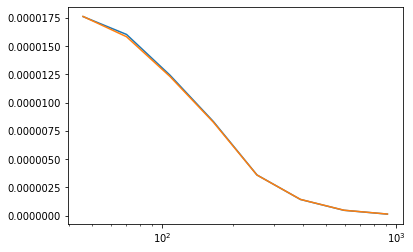

In [2545]:
plt.plot(ells, w_from_prime)
plt.plot(ells, wLcalculated)
plt.xscale('log')

In [1735]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), allresults)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.0000000000000187

In [1736]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), mvVector)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.0000000000000062

In [1737]:
a1 = np.sqrt(allresults[:, 0]/w_from_prime)
a2 = np.sqrt(allresults[:, 1]/(w_from_prime))
a3 = np.sqrt(allresults[:, 2]/(w_from_prime))
a1+a2+a3

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


array([       nan,        nan,        nan, 1.01168623, 0.86266051,
              nan,        nan,        nan])

In [1456]:
allresults[:, 0]*allresults[:, 1]*2/allresults[:, 5]**2

array([ 3.06668402e+00,  5.03055936e-03, -1.23616930e+00,  3.69471362e-01,
       -6.13607462e+00,  5.79958446e-01, -5.33964286e-01,  1.63035439e-01])

In [1144]:
result

    fjac: array([[-1.00000000e+00, -3.16067977e-10, -4.58581922e-11],
       [ 3.18544125e-10, -9.97421326e-01, -7.17683600e-02],
       [ 2.30562759e-11,  7.17683600e-02, -9.97421326e-01]])
     fun: array([-1.66126433e-67, -1.73479572e-64, -3.07029539e-65])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 18
     qtf: array([1.66126489e-67, 1.75235725e-64, 1.81734367e-65])
       r: array([ 4.06882520e-74,  2.09082465e-76,  2.04364940e-74,  2.20510992e-76,
       -4.80360538e-76, -3.61961890e-77])
  status: 5
 success: False
       x: array([2.98718331e+10, 2.98718331e+10, 5.97436662e+10])

In [1145]:
w_from_prime = (allresults[:, 0]+allresults[:, 1]+allresults[:, 2])**2
w_from_prime

array([7.16972284e-39, 7.20322930e-13, 6.31229704e-13, 7.03753431e-13,
       3.15650594e-49, 5.15454687e-55, 1.26543217e-12, 2.82258267e-56])

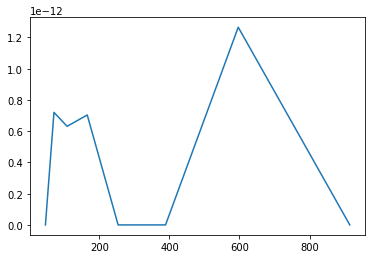

In [1146]:
plt.plot(ells, w_from_prime)

In [1110]:
def function(x):
    A0 = getA0v2(x)
    return np.array([A0.T@Z1@A0, A0.T@Z2@A0, A0.T@Z3@A0])

result = optimize.root(function, np.array([0., 0., 0.]), method = 'hybr', 
                       options = {'maxfev': 10000, 'xtol': 1e-4, 'ftol': 1e-20})

/home/r/rbond/omard/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: OptimizeWarning: Unknown solver options: ftol
  


In [1111]:
result

    fjac: array([[-0.1845615 , -0.00587346,  0.98280342],
       [-0.98086603, -0.0619399 , -0.18456784],
       [ 0.0619588 , -0.9980626 ,  0.00567064]])
     fun: array([ 4.96055172e-38, -6.30358846e-37,  2.42016379e-36])
 message: 'The solution converged.'
    nfev: 128
     qtf: array([ 2.37309236e-36, -4.56296414e-37,  6.45934974e-37])
       r: array([ 1.48840628e-39, -2.68261467e-41, -1.80435489e-38,  1.16094875e-42,
        5.40541663e-40,  9.86167271e-41])
  status: 1
 success: True
       x: array([-4.56384629e+05, -8.79416958e+07, -1.51336394e+04])

In [1093]:
AA = getA0(result.x)

In [1094]:
AA[0]*AA[1]*2/AA[5]**2

1.0000000000244442

In [1095]:
AA[0]*AA[2]*2/AA[4]**2

0.9999999999998727

In [1096]:
AA[1]*AA[2]*2/AA[3]**2

1.0000000000525846

In [1102]:
w_from_prime = (AA[0]+AA[1]+AA[2])**2/getNormStd(1)**2
w_from_prime

7.266959708038979e-13

In [1008]:
def functionscalar(x):
    return function(x).sum()

In [957]:
x0 = np.array([0., 0., 0.])
resultdiff = my.diffev(functionscalar, x0, ftol = 1e-16, gtol = 1000, maxiter = 1024**3, maxfun = 1024**3)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1000
         Function evaluations: 4004


In [958]:
resultdiff

array([ 0.00400217, -0.01896953,  0.02248795])

In [959]:
functionscalar(resultdiff)

4.02290417927903e-12

In [960]:
functionscalar(x0)

6.781068985914357e-12

In [961]:
functionscalar(result.x)

6.561834307758401e-23

In [962]:
result

    fjac: array([[-1.52788397e-03, -9.96285560e-01, -8.60973171e-02],
       [ 2.36743033e-02, -8.61093238e-02,  9.96004373e-01],
       [ 9.99718557e-01,  5.16514883e-04, -2.37179316e-02]])
     fun: array([1.41610461e-24, 4.34991156e-24, 5.98523269e-23])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last five Jacobian evaluations.'
    nfev: 80
     qtf: array([-9.48904249e-24,  5.92721367e-23, -1.62054006e-27])
       r: array([-1.08113487e-10, -1.24821386e-09, -9.24870975e-10, -3.55355443e-11,
       -1.59860730e-10,  1.00103392e-12])
  status: 4
 success: False
       x: array([-4.69436603e-02, -2.12043150e-04, -1.84000622e-05])

In [963]:
function(result.x)

array([1.41610461e-24, 4.34991156e-24, 5.98523269e-23])

In [964]:
result.x

array([-4.69436603e-02, -2.12043150e-04, -1.84000622e-05])

In [965]:
A0 = getA0(result.x)
A0

array([3.01402898e-08, 1.84643538e-10, 8.22808619e-07, 1.74313663e-08,
       2.22709184e-07, 3.33622813e-09])

In [966]:
A0[0]*A0[1]*2

1.1130419518994896e-17

In [967]:
A0[5]**2

1.1130418102890283e-17

In [968]:
A0 = getA0(resultdiff)
A0

array([-1.16725071e-06, -2.33676908e-07, -1.67293176e-06,  9.84360402e-07,
        2.78066884e-06, -7.44749132e-07])

In [913]:
A0[0]*A0[1]*2

0.006094021180574725

In [914]:
A0[5]**2

0.013021007552113486

In [915]:
getstandardA0()

array([3.02438463e-08, 1.88189519e-10, 8.22032609e-07, 1.75896516e-08,
       2.22986223e-07, 3.37389238e-09])

In [916]:
function(result.x)

array([8.20584173e-06, 2.55431313e-06, 4.96668656e-05])

In [177]:
mvVector = lambda_over_2*np.einsum('...ij, j -> ...i', invMandel, C)-FB*bias*np.einsum('...ij, ...j -> ...i', invMandel, Bvec)

NameError: name 'lambda_over_2' is not defined

In [178]:
Vec = 1/Norm*np.einsum('...ij, j -> ...i', invMandel, C)+FB*bias*np.einsum('...ij, ...j -> ...i', invMandel, (O/Norm)*C-Bvec)

NameError: name 'invMandel' is not defined

In [64]:
AA = np.einsum('...ij, j -> ...i', invMandel, C)

In [65]:
index = 1

In [66]:
AA[index, 0]*AA[index, 1]*2/(AA[index, 5]**2)

1.0000000000464384

In [67]:
Bvec[index]

array([0.0056652 , 0.00294179, 0.00423567, 0.0048665 , 0.00601772,
       0.00671335])

In [68]:
C

array([1.        , 1.        , 1.        , 1.41421356, 1.41421356,
       1.41421356])

In [69]:
BB = np.einsum('...ij, ...j -> ...i', invMandel, Bvec)

In [70]:
BB[index, 0]*BB[index, 1]*2/(BB[index, 5]**2)

0.7212781737789982

In [73]:
Vec

array([[-1.44994979e-04, -8.20513850e-06, -2.04424744e-04,
         6.46332131e-05,  2.48317800e-04, -4.77557087e-05],
       [-9.70120933e-05, -1.22552332e-05, -1.78290951e-04,
         7.67736715e-05,  1.97598649e-04, -5.75265566e-05],
       [-4.95555499e-05, -2.95556825e-06, -6.29192083e-05,
         2.16475612e-05,  8.61908957e-05, -1.61637577e-05],
       [-1.06390661e-05, -4.26969260e-07, -3.99318637e-06,
         3.74136317e-06,  1.68229949e-05, -3.39412476e-06],
       [-6.19749229e-06, -1.83407688e-08, -6.07927980e-06,
         1.16519744e-06,  1.12877144e-05, -1.12192767e-06],
       [-1.02672514e-06, -1.70466699e-07, -2.04298487e-06,
         1.17877990e-06,  2.95384265e-06, -8.86408258e-07],
       [-2.02975271e-07,  4.29119239e-08, -3.06898133e-07,
         1.13080201e-07,  6.72892387e-07, -1.84313428e-07],
       [-3.85702994e-08, -1.04510403e-08, -2.22479673e-07,
         9.82974667e-08,  2.09198982e-07, -7.15535920e-08]])

In [72]:
mvVector.shape

(8, 6)

In [699]:
check = np.einsum('ij, ...j -> ...i', (P+np.sqrt(2)*Q), mvVector)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.000000000000006

In [700]:
noiseAL = np.einsum('...i, ...ij, ...j -> ...', mvVector, MandelMatrix, mvVector)
np.sqrt(integrate_discrete(noiseAL, ells))

0.008324484606545696

In [701]:
bias

1.1613386332893011e-07

In [702]:
selection = abs(mvVector)<1e-10
mvVector[selection] *= 0.

In [703]:
wLcalculated = mvVector[:, 0:3].sum(axis = 1)+np.sqrt(2)*mvVector[:, 3:6].sum(axis = 1)
wLcalculated

array([1.76071503e-05, 1.58141153e-05, 1.22961065e-05, 8.24911785e-06,
       3.58958007e-06, 1.43718319e-06, 4.80760753e-07, 1.41727943e-07])

In [704]:
integrate_discrete(wLcalculated, ells)

1.0000000000000062

In [705]:
mvVector[:, 0]+mvVector[:, 1]+mvVector[:, 2]+np.sqrt(2)*(mvVector[:, 3]+mvVector[:, 4]+mvVector[:, 5])

array([1.76071503e-05, 1.58141153e-05, 1.22961065e-05, 8.24911785e-06,
       3.58958007e-06, 1.43718319e-06, 4.80760753e-07, 1.41727943e-07])

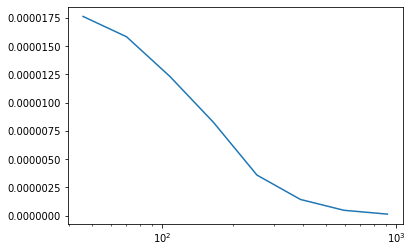

In [706]:
plt.plot(ells, wLcalculated)
plt.xscale('log')

In [707]:
mvVector[:, 0]

array([6.11161687e-06, 4.00463067e-06, 2.09114391e-06, 1.07778138e-06,
       3.81810343e-07, 6.11293933e-08, 7.56108644e-09, 8.52674483e-10])

In [708]:
mvVector[:, 1]

array([1.01803115e-06, 5.94625374e-07, 2.09062210e-07, 5.47366078e-08,
       2.02177199e-08, 2.75535117e-08, 5.34084846e-09, 7.13654733e-10])

In [709]:
mvVector[:, 2]

array([2.29586026e-05, 1.76490071e-05, 1.17091882e-05, 6.86190185e-06,
       2.67483835e-06, 1.28531545e-06, 4.67834906e-07, 1.40431772e-07])

In [710]:
mvVector[:, 3]

array([-3.89607518e-06, -2.24337954e-06, -9.97693162e-07, -3.90691674e-07,
       -1.34315296e-07, -1.31185183e-07, -4.05220569e-08, -5.40905758e-09])

In [711]:
mvVector[:, 4]

array([-7.71575471e-06, -3.89706952e-06, -9.22081192e-07,  3.42437144e-07,
        4.19586683e-07,  1.50813484e-07,  3.91335121e-08,  5.09177877e-09])

In [712]:
mvVector[:, 5]

array([2.78635920e-06, 1.59081950e-06, 7.08296925e-07, 2.28353219e-07,
       7.72719186e-08, 2.50501259e-08, 1.40545348e-09, 1.26247904e-10])

In [713]:
np.sqrt(mvVector[:, 0]*mvVector[:, 1]*2)

array([3.52755337e-06, 2.18231758e-06, 9.35071299e-07, 3.43494096e-07,
       1.24252441e-07, 5.80401491e-08, 8.98694797e-09, 1.10319099e-09])

In [714]:
a2 = mvVector[:, 5]**2/mvVector[:, 0]/wLcalculated/2
a1 = mvVector[:, 5]**2/mvVector[:, 1]/wLcalculated/2
a3 = mvVector[:, 3]**2/mvVector[:, 1]/wLcalculated/2

In [715]:
# Aprime = w*A

In [716]:
A1prime = np.sqrt(mvVector[..., 0]) 
A1prime

array([2.47216846e-03, 2.00115733e-03, 1.44607880e-03, 1.03816250e-03,
       6.17908038e-04, 2.47243591e-04, 8.69545079e-05, 2.92005905e-05])

In [717]:
A2prime = np.sqrt(mvVector[..., 1])
A2prime

array([1.00897530e-03, 7.71119559e-04, 4.57233212e-04, 2.33958560e-04,
       1.42189029e-04, 1.65992505e-04, 7.30811088e-05, 2.67143170e-05])

In [718]:
A3prime = np.sqrt(mvVector[..., 2])
A3prime

array([0.00479151, 0.00420107, 0.00342187, 0.00261952, 0.00163549,
       0.00113372, 0.00068398, 0.00037474])

In [719]:
print(np.sqrt(2)*A1prime*A2prime)
print(mvVector[..., 5])

[3.52755337e-06 2.18231758e-06 9.35071299e-07 3.43494096e-07
 1.24252441e-07 5.80401491e-08 8.98694797e-09 1.10319099e-09]
[2.78635920e-06 1.59081950e-06 7.08296925e-07 2.28353219e-07
 7.72719186e-08 2.50501259e-08 1.40545348e-09 1.26247904e-10]


In [720]:
print(np.sqrt(2)*A1prime*A3prime)
print(mvVector[..., 4])

[1.67519660e-05 1.18893023e-05 6.99794221e-06 3.84594073e-06
 1.42918225e-06 3.96410277e-07 8.41111189e-08 1.54753087e-08]
[-7.71575471e-06 -3.89706952e-06 -9.22081192e-07  3.42437144e-07
  4.19586683e-07  1.50813484e-07  3.91335121e-08  5.09177877e-09]


In [721]:
print(np.sqrt(2)*A2prime*A3prime)
print(mvVector[..., 3])

[6.83704216e-06 4.58138570e-06 2.21266752e-06 8.66714752e-07
 3.28874239e-07 2.66138890e-07 7.06913763e-08 1.41576692e-08]
[-3.89607518e-06 -2.24337954e-06 -9.97693162e-07 -3.90691674e-07
 -1.34315296e-07 -1.31185183e-07 -4.05220569e-08 -5.40905758e-09]


In [722]:
check = np.einsum('ij, ...j -> ...j', (P+np.sqrt(2)*Q), mvVector)
check = np.einsum('...i, i -> ...', check, E)
print(check.shape)
integrate_discrete(check, ells)

(8,)


1.000000000000006

In [723]:
invsigma2 = np.nan_to_num(theta[0, 0, 0, 0, :]**-1)
invsigma2[1] = 0.
factor = integrate_discrete(invsigma2, ells)
invvarweights_hu_ok = invsigma2*factor**-1

In [724]:
Optimizerkk = best.Opt(['hu_ok', 'shear', 'bh'], 30, 1200, ells, ells*0.+1., 
                       np.nan_to_num(theta), np.nan_to_num(B), np.nan_to_num(N))

In [725]:
optversion = {'weights_name': 'absbias', 'sum_biases_squared': False, 'abs_biases': True, 'bias_squared': False,
                      'color': 'purple', 'latexformula': '\sigma^2(\hat{A}_{\rm{comb}})+\left(\int_{\vec{L}}\vec{a}^TB\vec{a}\right)^2'}

In [467]:
result = Optimizerkk.optimize(optversion, method = 'diff-ev', gtol = 500 ,bounds = [-4, 4]
                              ,noisebiasconstr = False, fb = FB, inv_variance = False)

Start optimization with diff-ev
Doing for absbias
Generation 0 has ChiSquare: 0.000456
Generation 100 has ChiSquare: 0.000137
Generation 200 has ChiSquare: 0.000098
Generation 300 has ChiSquare: 0.000088
Generation 400 has ChiSquare: 0.000080
Generation 500 has ChiSquare: 0.000076
Generation 600 has ChiSquare: 0.000073
Generation 700 has ChiSquare: 0.000071
Generation 800 has ChiSquare: 0.000070
Generation 900 has ChiSquare: 0.000070
Generation 1000 has ChiSquare: 0.000070
Generation 1100 has ChiSquare: 0.000069
Generation 1200 has ChiSquare: 0.000069
Generation 1300 has ChiSquare: 0.000069
Generation 1400 has ChiSquare: 0.000069
Generation 1500 has ChiSquare: 0.000069
Generation 1600 has ChiSquare: 0.000069
Generation 1700 has ChiSquare: 0.000069
Generation 1800 has ChiSquare: 0.000069
Generation 1900 has ChiSquare: 0.000069
Generation 2000 has ChiSquare: 0.000069
Generation 2100 has ChiSquare: 0.000069
Generation 2200 has ChiSquare: 0.000069
Generation 2300 has ChiSquare: 0.000069
Ge

In [726]:
a1code, a2code, a3code, w = result.ws

In [727]:
w

array([1.76094368e-05, 1.58147032e-05, 1.22971389e-05, 8.24933033e-06,
       3.59026379e-06, 1.43709131e-06, 4.80650297e-07, 1.41684692e-07])

In [728]:
integrate_discrete(w, ells)

1.0

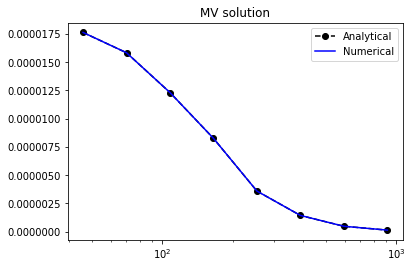

In [729]:
plt.title('MV solution')
plt.plot(ells, wLcalculated, ls = '--', label = 'Analytical', color = 'black', marker = 'o')
plt.plot(ells, w, label = 'Numerical', color = 'blue')
plt.xscale('log')
plt.legend()

In [730]:
w_from_prime = (A1prime+A2prime+A3prime)**2
w_from_prime

array([6.84368598e-05, 4.86275967e-05, 2.83575540e-05, 1.51448951e-05,
       5.73885323e-06, 2.39306554e-06, 7.12370093e-07, 1.85465609e-07])

In [731]:
a1 = np.nan_to_num(A1prime/np.sqrt(w_from_prime))
a2 = np.nan_to_num(A2prime/np.sqrt(w_from_prime))
a3 = np.nan_to_num(A3prime/np.sqrt(w_from_prime))
a1+a2+a3

array([1., 1., 1., 1., 1., 1., 1., 1.])

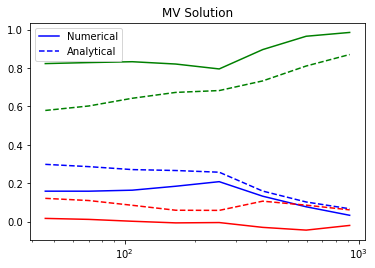

In [732]:
plt.title('MV Solution')

plt.plot(ells, a1code, color = 'blue', label = 'Numerical')
plt.plot(ells, a2code, color = 'red')
plt.plot(ells, a3code, color = 'green')

plt.plot(ells, a1, ls = '--', color = 'blue', label = 'Analytical')
plt.plot(ells, a2, ls = '--', color = 'red')
plt.plot(ells, a3, ls = '--', color = 'green')
plt.xscale('log')
plt.legend()

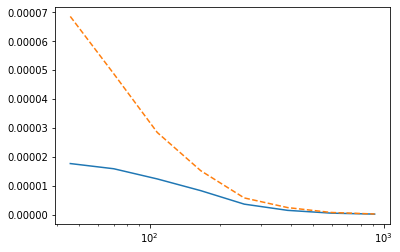

In [733]:
plt.plot(ells, w)
plt.plot(ells, w_from_prime, ls = '--')
plt.xscale('log')

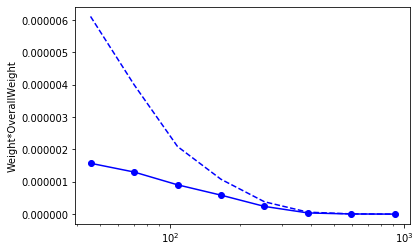

In [734]:
plt.plot(ells, a1**2*w, color = 'blue', marker = 'o')
#plt.plot(ells, a2**2*w, color = 'red', marker = 'o')
#plt.plot(ells, a3**2*w, color = 'green', marker = 'o')
plt.plot(ells, A1prime**2, ls = '--', color = 'blue')

plt.ylabel('Weight*OverallWeight')

#plt.plot(ells, A2prime**2, ls = '--', color = 'red')
#plt.plot(ells, A3prime**2, ls = '--', color = 'green')
plt.xscale('log')

In [477]:
K.shape

(6, 6)

In [ ]:
class AnalyticalConstrainedOpt():
    def __init__(self, ells, invM, Bvec, constrainted_components = [3, 4, 5]):
        '''
        M, Bvec already divided by Ckk^2, Ckk respectively
        '''
        
        self.E = np.ones(6)
        self.P = self.getP()
        self.Q = self.getQ()
        
        self.invM = invM
        self.B = Bvec
        
        self.K = self.P+np.sqrt(2)*self.Q
        
        self.ells = ells
        
        self.C = np.einsum('i, ij -> j', self.E.T, K)
        mvnorm = np.einsum('ij, ...jk, k, i -> ...', self.K, self.invM, self.C, self.E)
        self.mvnorm = self.integrate(mvnorm, self.ells)
        
        #int K M^-1 B dot E
        b_prefactor = np.einsum('ij, ...jk, ...k, i -> ...', self.K, self.invM, self.B, self.E)
        self.b_prefactor = self.integrate(b_prefactor, self.ells)
        
        lambda_i_prefactor = []
        for i in constrainted_components:
            temp = np.einsum('ij, ...jk, k, i', self.K, self.invM, self.getPi(i), self.E)
            lambda_i_prefactor += [self.integrate(temp, ells)]
        self.lambda_i_prefactor = np.array(lambda_i_prefactor)
        
        
        self.Lambda_lambda = np.einsum('...ij, k, kj -> ...i', self.invM, self.E.T, self.K)
        self.Lambda_b = np.einsum('...ij, ...j -> ...i', self.invM, self.B)
        
        self.Lambda_lambda_i = {}
        self.Lambda_lambda_i_list = []
        for i in constrainted_components:
            self.Lambda_lambda_i[i] = np.einsum('...ij, j -> ...i', self.invM, self.getPi(i))
            self.Lambda_lambda_i_list += [self.Lambda_lambda_i[i]]
            
        self.Lambda_lambda_i_list = np.array(self.Lambda_lambda_i_list)
        self.Lambda_lambda_i_list = np.rollaxis(self.Lambda_lambda_i_list, 0, self.Lambda_lambda_i_list.ndim)
            
        Ncomp = len(constrainted_components)
        Nells = len(self.ells)
        
        self.Cijs = np.zeros((Nells, Ncomp, Ncomp))
        for i, component in enumerate(constrainted_components):
            for j in range(Ncomp):
                self.Cijs[:, j, i] = self.Lambda_lambda_i[component][:, j] #Note order of index
                                
        self.invCijs = np.linalg.inv(self.Cijs)
        
        self.C_lambda = self.Lambda_lambda[:, 3:] #NOTE
        self.C_b = self.Lambda_b[:, 3:]
                
        self.super_b_prefactor = np.einsum('...ij, ...j,  i-> ...', self.invCijs, self.C_b, self.lambda_i_prefactor)
        
        self.super_lambda_prefactor = self.mvnorm+np.einsum('...ij, ...j,  i-> ...', self.invCijs, self.C_lambda, self.lambda_i_prefactor)
        
        
        
        
    def getPi(self, i):
        P = np.zeros(6)
        P[i] = 1
        return P
        
    def getP(self):
        P = np.zeros((6, 6))
        P[0, 0] = 1
        P[1, 1] = 1
        P[2, 2] = 1
        return P
    
    def getQ(self):
        Q = np.zeros((6, 6))
        Q[3, 3] = 1
        Q[4, 4] = 1
        Q[5, 5] = 1
        return Q
    
    
    
    
    def integrate(self, y, ells):
        factor = 4*np.pi
        return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor

    

In [ ]:
A = AnalyticalConstrainedOpt(ells, invMandel, Bvec)

In [ ]:
dic = u.dictionary(directory, lmax_directory)